In [1]:
%pylab inline
import pandas as pd
import sys
import gc
import os
import xgboost as lgb

Populating the interactive namespace from numpy and matplotlib


In [2]:
FOLD=int(os.getenv("FOLD"))

In [3]:
print FOLD

2


In [4]:
sys.path.insert(0,"../python/rrvf2017/")

In [5]:
from rrvf_data import   DataGen, normalize
import rrvf_data

In [6]:
def get_index(cols,columns):
    lst=[]
    for c in cols:
        lst.append(np.where(columns==c)[0][0])
    return np.array(lst)

In [7]:
def read_data(offset):
    columns,data=rrvf_data.read_data( offset,"../input/train_test_extb.npy.npz")
    rawy=data[:,:,get_index(['visitors'],columns)[0]].copy()
    print len(columns),data.shape,rawy.shape    
    return columns,data,rawy

In [8]:
gc.collect()

0

# cv

In [9]:
n_reg_lookback=7
n_lookforward=1
n_offset=0

In [10]:
lag_cols=array(['visitor_ma28', 'visitor_ma56', 'visitor_ma14', 'visitor_ma112', 'visitor_ma224', 
                'visitor_ma7', 'visitor_sma8', 'visitor_sma4', 'visitor_sma3', 'visitor_sma16', 
                'visitor_sma2', 'visitor_ma4', 'visitor_ma2', 'visitors', 'visitor_lag7', 
                'visitor_lag14', 'visitor_lag28', 'visitor_lag91', 'visitor_lag182', 'geo2_visitors_mean', 
                'station_visitors_mean', 'geo2_count_y1', 'all_count_y1', 'geo1_visitors_mean', 'all_count_y3', 
                'station_count_y3', 'station_count_y4',
               's16_y_nan', 's16_y_std', 's16_y1_ratio', 's16_y2_ratio',
               'bad_ratio'])
len(lag_cols)

32

In [11]:
def make_ondate_train_test(ondate_cols,data,columns):
    ondate_train_test=np.round(data[:,:,get_index(ondate_cols,columns)].copy(),2)
    ondate_train_test=normalize(ondate_train_test)
    v=np.zeros_like(ondate_train_test[:,:,0])
    for i in range(v.shape[0]): v[i]=i
    #ondate_train_test = np.concatenate([np.expand_dims(v,-1),ondate_train_test],axis=-1)
    print ondate_train_test.shape
    return ondate_train_test

In [12]:
ondate_cols =array(['const_one', 'visitor_lag91', 'visitor_lag182', 'TMIN', 'holiday', 'TAVG','f_t',
                    'weekday6', 'weekday5', 'weekday4', 'weekday3', 'weekday2', 'weekday1', 'weekday0',
                    'rv_sum', 'rv_mean', 'rv_gap_mean', 'rv_gap_weighted_mean'
                   ])

In [13]:
def make_lag_train_test(lag_cols,data,columns):
    lag_train_test=data[:,:,get_index(lag_cols,columns)].copy()
    #lag_train_test=normalize(lag_train_test)
    print lag_train_test.shape
    return lag_train_test

In [14]:
from sklearn.model_selection import GridSearchCV,ParameterGrid,ParameterSampler
from sklearn.metrics import  make_scorer
from multiprocessing import Pool

# time split

In [15]:
import cPickle as pickle
indexes=rrvf_data.get_train_valid_indexes()

In [16]:
def make_Xy(data_from_gen):
    print data_from_gen[0]['ondatex'].shape,data_from_gen[0]['lagx'].shape,data_from_gen[0]['masky'].shape,data_from_gen[1].shape
    X=np.concatenate([data_from_gen[0]['ondatex'].reshape([data_from_gen[0]['ondatex'].shape[0],-1]),
                    data_from_gen[0]['lagx'].reshape([data_from_gen[0]['lagx'].shape[0],-1])],axis=1)
    y=np.squeeze(data_from_gen[1])
    mask=np.squeeze(data_from_gen[0]['masky'].reshape([data_from_gen[0]['masky'].shape[0],-1]))
    print X.shape,y.shape,mask.shape
    mask= (mask>0) & (y>0)
    X=X[mask]
    y=y[mask]
    dataidx=data_from_gen[3][mask]
    assert X.shape[0]==y.shape[0]
    return X,y,dataidx

In [17]:
from sklearn.metrics import mean_squared_error
def make_model(i, trainX,trainy, validX,validy, colsample_bytree=1,max_depth=4,subsample=1,C=0.1,
                                    learning_rate=0.03,min_child_weight=1,objective='reg:l1f0',
                                     gamma=0,reg_alpha=0,reg_lambda=1 ):
        models=[]
        scores=[]
        d_train = lgb.DMatrix(trainX, label=trainy)
        d_valid = lgb.DMatrix(validX, label=validy)
        
        if 1:
            params = {}
            params['eta'] = learning_rate
            params['objective'] = objective
            params['eval_metric'] = 'rmse'
            params['max_depth'] = max_depth
            params['colsample_bytree'] = colsample_bytree
            params['subsample'] = subsample
            params['min_child_weight'] = min_child_weight 
            params['gamma'] = gamma            
            params['reg_alpha'] = reg_alpha            
            params['reg_lambda'] = reg_lambda            
            params['silent'] = 1
            params['nthread'] = 8
            params['tree_method']='hist'
            print i, params
            watchlist = [(d_train, 'train'), (d_valid, 'valid')]
            
            gbm = lgb.train(params, d_train, 1000, watchlist, early_stopping_rounds=50, verbose_eval=50)


            models.append(gbm)
            validpred=gbm.predict(d_valid,ntree_limit=gbm.best_ntree_limit)
            scores.append(mean_squared_error(validy,validpred))
            print mean_squared_error(trainy,gbm.predict(d_train,ntree_limit=gbm.best_ntree_limit)), scores[-1]
        print scores
        print i, "mean score", np.mean(scores)
        return models[0],np.mean(scores),validpred
        #return np.mean(scores) 

In [18]:
def f(iparam,trainX,trainy,validX,validy):
    i,param=iparam
    return make_model(i,trainX,trainy,validX,validy, **param)

In [19]:
import rrvf_data
def g(model,testX,testy,testidx,n_offset):
    d_test = lgb.DMatrix(testX, label=testy)    
    test_pred=model.predict(d_test,ntree_limit=model.best_ntree_limit)    
    df=pd.DataFrame({'y':testy})
    df['pred']=test_pred
    df['dayidx']=testidx[:,1]+n_offset
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    print df2['error2'].mean()
    display(df2)
    return  df2['error2'].mean()

def g2(model,train_gen,offset):
    predlist=[]
    ylist=[]
    daylist=[]
    for i in range(7):
        i=478-7+i-offset
        Xdict,y,dataidx,_=train_gen.get_by_t2(day=i)
        X=np.concatenate([Xdict['ondatex'].reshape([Xdict['ondatex'].shape[0],-1]),
                    Xdict['lagx'].reshape([Xdict['lagx'].shape[0],-1])],axis=1)
        d_test = lgb.DMatrix(X)    
        pred=model.predict(d_test,ntree_limit=model.best_ntree_limit).reshape(-1)
        predlist.append(pred)
        daylist.append(np.zeros_like(pred,dtype=int)+i+offset)
        ylist.append(y.reshape(-1))
    ylist=np.concatenate(ylist)
    predlist=np.concatenate(predlist)
    daylist=np.concatenate(daylist)
    df=pd.DataFrame({'y':ylist,'dayidx':daylist,'pred':predlist})
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    print df2['error2'].mean()
    display(df2)
    return  df2['error2'].mean()

PRED_DATE=478
def h(model,train_gen):
    Xdict,_,dataidx,_=train_gen.get_by_t2(day=PRED_DATE)
    X=np.concatenate([Xdict['ondatex'].reshape([Xdict['ondatex'].shape[0],-1]),
                    Xdict['lagx'].reshape([Xdict['lagx'].shape[0],-1])],axis=1)
    #mask=np.squeeze(Xdict['masky'].reshape([Xdict.shape[0],-1]))
    print X.shape
    d_test = lgb.DMatrix(X)    
    pred=model.predict(d_test,ntree_limit=model.best_ntree_limit)

    return pred,dataidx


In [20]:
parameter={'colsample_bytree': 0.5,
 'learning_rate': 0.03,
 'max_depth': 8,
 'min_child_weight': 1,
 'objective': 'reg:linear',
 'subsample': 1}

In [21]:
EXCLUDE_HARD=False
def _run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    assert n_offset+1==n_lookforward
    batchsize=128
    ondate_train_test=make_ondate_train_test(ondate_cols,data,columns)
    lag_train_test = make_lag_train_test(lag_cols,data,columns)
    train_gen=rrvf_data.DataGen(lag_train_test,ondate_train_test, rawy,n_reg_lookback+1, 478,#478-1*7-39-n_offset, 
                      batchsize=batchsize,valid_split=0.1, indexes=index,lookforward_offset=n_offset,
                      exclude_hard=EXCLUDE_HARD,
                  lookback1=n_reg_lookback,  lookforward=n_lookforward, excluded_days=None)
    valid_gen=None
    test_gen=rrvf_data.DataGen(lag_train_test,ondate_train_test, rawy,478-1*7-n_offset,478, lookforward_offset=n_offset,
                     batchsize=batchsize,lookback1=n_reg_lookback, lookforward=n_lookforward)
    print train_gen.train_steps_per_epoch
    print 0 if valid_gen is None else valid_gen.train_steps_per_epoch
    
    train_data_from_gen=train_gen.get_train()
    trainX,trainy,_=make_Xy(train_data_from_gen)
    valid_data_from_gen=train_gen.get_valid()
    validX,validy,valididx=make_Xy(valid_data_from_gen)
    test_data_from_gen=test_gen.get_train()
    testX,testy,testidx=make_Xy(test_data_from_gen)

    model,score,validpred=f((-1,parameter),trainX,trainy,validX,validy)
    g(model,testX,testy,testidx,n_offset)
    g2(model,train_gen,n_offset)
    
    pred478=h(model,train_gen)
    return score,(validy,valididx,validpred),pred478

def run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    return _run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset)        

In [22]:
def MSE(a,b):
    idx= np.isnan(a) | np.isnan(b)
    a=a[~idx]
    b=b[~idx]
    #print np.mean(~idx)
    return np.mean((a-b)**2)
    return mean_squared_error(a,b)

In [23]:
def ff(offset):
    print "\n\n",offset
    columns,data,rawy=read_data(offset=offset)
    _,validpred,pred478=run_once(columns,data,rawy, indexes[j],ondate_cols,lag_cols,n_lookforward=offset,n_offset=offset-1)
    #validpreds[offset]=[validpred,pred478]
    return offset, [validpred,pred478]
    #pickle.dump(validpreds, open('3005_rf_fold{}_{}_d{}.pkl'.format(j, EXCLUDE_HARD, PRED_DATE),'wb'))    

In [24]:
j=FOLD
validpreds={}

In [25]:
p = Pool(4,maxtasksperchild=1)

In [26]:
results=p.map(ff, range(1,40),chunksize=1)

5


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 14.804288


(829, 517, 18)


(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (199872, 2) (50868, 2)


train/valid # (199872, 2) (50868, 2)


rand split across time


train has 199872 records out of 389630 records


valid has 50868 records out of 389630 records


train has 9119 records out of 9119 records


no valid set


1561


0


(199872, 1, 18) (199872, 7, 32) (199872, 1) (199872, 1)


(199872, 242) (199872,) (199872,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(50868, 1, 18) (50868, 7, 32) (50868, 1) (50868, 1)


(50868, 242) (50868,) (50868,)


(9119, 1, 18) (9119, 7, 32) (9119, 1) (9119, 1)


(9119, 242) (9119,) (9119,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[0]	train-rmse:2.37477	valid-rmse:2.36913


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


6


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 15.133374


(829, 517, 18)


(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (199872, 2) (50868, 2)


train/valid # (199872, 2) (50868, 2)


rand split across time


train has 199872 records out of 389630 records


valid has 50868 records out of 389630 records


train has 9948 records out of 9948 records


no valid set


1561


0


(199872, 1, 18) (199872, 7, 32) (199872, 1) (199872, 1)


(199872, 242) (199872,) (199872,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(50868, 1, 18) (50868, 7, 32) (50868, 1) (50868, 1)


(50868, 242) (50868,) (50868,)


(9948, 1, 18) (9948, 7, 32) (9948, 1) (9948, 1)


(9948, 242) (9948,) (9948,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[0]	train-rmse:2.36812	valid-rmse:2.3634


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[50]	train-rmse:0.716903	valid-rmse:0.72865


[100]	train-rmse:0.500895	valid-rmse:0.531715


[50]	train-rmse:0.716874	valid-rmse:0.729186


[150]	train-rmse:0.475994	valid-rmse:0.517029


7


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 16.310143


(829, 517, 18)


(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (199872, 2) (50868, 2)


train/valid # (199872, 2) (50868, 2)


[200]	train-rmse:0.466005	valid-rmse:0.514406


[100]	train-rmse:0.502212	valid-rmse:0.533843


rand split across time


train has 199872 records out of 389630 records


valid has 50868 records out of 389630 records


train has 10777 records out of 10777 records


no valid set


1561


0


8


(199872, 1, 18) (199872, 7, 32) (199872, 1) (199872, 1)


(1, 829, 517) (60, 829, 517)


(199872, 242) (199872,) (199872,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(50868, 1, 18) (50868, 7, 32) (50868, 1) (50868, 1)


(50868, 242) (50868,) (50868,)


(10777, 1, 18) (10777, 7, 32) (10777, 1) (10777, 1)


(10777, 242) (10777,) (10777,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 17.574337


(829, 517, 18)


(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (199872, 2) (50868, 2)


train/valid # (199872, 2) (50868, 2)


[0]	train-rmse:2.38516	valid-rmse:2.37533


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


rand split across time


train has 199872 records out of 389630 records


valid has 50868 records out of 389630 records


train has 11606 records out of 11606 records


no valid set


1561


0


(199872, 1, 18) (199872, 7, 32) (199872, 1) (199872, 1)


(199872, 242) (199872,) (199872,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(50868, 1, 18) (50868, 7, 32) (50868, 1) (50868, 1)


(50868, 242) (50868,) (50868,)


(11606, 1, 18) (11606, 7, 32) (11606, 1) (11606, 1)


(11606, 242) (11606,) (11606,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[250]	train-rmse:0.457581	valid-rmse:0.513182


[0]	train-rmse:2.39742	valid-rmse:2.38862


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[150]	train-rmse:0.477141	valid-rmse:0.519076


[50]	train-rmse:0.716921	valid-rmse:0.72818


[300]	train-rmse:0.45058	valid-rmse:0.512519


[50]	train-rmse:0.719116	valid-rmse:0.731621


[350]	train-rmse:0.444779	valid-rmse:0.512226


[200]	train-rmse:0.46711	valid-rmse:0.516443


[100]	train-rmse:0.498797	valid-rmse:0.530979


[400]	train-rmse:0.438521	valid-rmse:0.511968


[150]	train-rmse:0.473557	valid-rmse:0.516375


[250]	train-rmse:0.458987	valid-rmse:0.515195


[100]	train-rmse:0.498761	valid-rmse:0.532202


[450]	train-rmse:0.433395	valid-rmse:0.511777


[200]	train-rmse:0.46339	valid-rmse:0.513674


[500]	train-rmse:0.428313	valid-rmse:0.511573


[300]	train-rmse:0.45221	valid-rmse:0.514603


[150]	train-rmse:0.473345	valid-rmse:0.516874


[250]	train-rmse:0.456709	valid-rmse:0.512686


[550]	train-rmse:0.423035	valid-rmse:0.511489


[350]	train-rmse:0.446306	valid-rmse:0.514297


[300]	train-rmse:0.450941	valid-rmse:0.512108


[600]	train-rmse:0.417999	valid-rmse:0.511467


[200]	train-rmse:0.462836	valid-rmse:0.513879


[350]	train-rmse:0.445114	valid-rmse:0.511681


[400]	train-rmse:0.440578	valid-rmse:0.513939


[650]	train-rmse:0.412193	valid-rmse:0.511382


[400]	train-rmse:0.439407	valid-rmse:0.511342


[250]	train-rmse:0.455397	valid-rmse:0.512758


[700]	train-rmse:0.406983	valid-rmse:0.511371


[450]	train-rmse:0.434526	valid-rmse:0.513645


[450]	train-rmse:0.433668	valid-rmse:0.511078


Stopping. Best iteration:
[684]	train-rmse:0.408541	valid-rmse:0.511348



[300]	train-rmse:0.448451	valid-rmse:0.512061


0.16690609 0.26147655


[0.26147655]


-1 mean score 0.26147655


0.17292137444


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.892853  0.036257  0.193605    7  2017-04-16
472     2.507290  2.535108 -0.027817  0.179836    1  2017-04-17
473     2.661330  2.647972  0.013358  0.180962    2  2017-04-18
474     2.754815  2.749174  0.005641  0.173517    3  2017-04-19
475     2.713762  2.710456  0.003305  0.201018    4  2017-04-20
476     2.999000  2.976574  0.022426  0.133283    5  2017-04-21
477     3.075529  3.079360 -0.003830  0.148228    6  2017-04-22

0.17292137444


pred         y     error    error2  day        date
dayidx                                                         
471     2.892853  2.929110  0.036257  0.193605    7  2017-04-16
472     2.535108  2.507290 -0.027817  0.179836    1  2017-04-17
473     2.647972  2.661330  0.013358  0.180962    2  2017-04-18
474     2.749174  2.754815  0.005641  0.173517    3  2017-04-19
475     2.710456  2.713762  0.003305  0.201018    4  2017-04-20
476     2.976574  2.999000  0.022426  0.133283    5  2017-04-21
477     3.079360  3.075529 -0.003830  0.148228    6  2017-04-22

(829, 242)


9


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 18.806503


(829, 517, 18)


(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


[500]	train-rmse:0.429369	valid-rmse:0.513509


train/valid # (199872, 2) (50868, 2)


train/valid # (199872, 2) (50868, 2)


[500]	train-rmse:0.428185	valid-rmse:0.511028


rand split across time


train has 199872 records out of 389630 records


valid has 50868 records out of 389630 records


train has 12435 records out of 12435 records


no valid set


1561


0


(199872, 1, 18) (199872, 7, 32) (199872, 1) (199872, 1)


(199872, 242) (199872,) (199872,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(50868, 1, 18) (50868, 7, 32) (50868, 1) (50868, 1)


(50868, 242) (50868,) (50868,)


(12435, 1, 18) (12435, 7, 32) (12435, 1) (12435, 1)


(12435, 242) (12435,) (12435,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[0]	train-rmse:2.39737	valid-rmse:2.38586


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[350]	train-rmse:0.442411	valid-rmse:0.51168


[550]	train-rmse:0.423193	valid-rmse:0.510806


[550]	train-rmse:0.423875	valid-rmse:0.513347


[600]	train-rmse:0.418025	valid-rmse:0.510675


[400]	train-rmse:0.437257	valid-rmse:0.5114


[600]	train-rmse:0.419156	valid-rmse:0.513238


[50]	train-rmse:0.723565	valid-rmse:0.735873


[650]	train-rmse:0.41345	valid-rmse:0.510589


[450]	train-rmse:0.431537	valid-rmse:0.5112


[650]	train-rmse:0.414385	valid-rmse:0.513119


[700]	train-rmse:0.409045	valid-rmse:0.510552


[500]	train-rmse:0.426113	valid-rmse:0.511024


[700]	train-rmse:0.410316	valid-rmse:0.513154


Stopping. Best iteration:
[650]	train-rmse:0.414385	valid-rmse:0.513119



[100]	train-rmse:0.504298	valid-rmse:0.539097


0.17171502 0.26329127


[0.26329127]


-1 mean score 0.26329127


0.178758174181


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.916094  0.013016  0.204615    7  2017-04-16
472     2.507290  2.545309 -0.038018  0.187599    1  2017-04-17
473     2.661330  2.643776  0.017554  0.198449    2  2017-04-18
474     2.754815  2.736121  0.018694  0.176844    3  2017-04-19
475     2.713762  2.709919  0.003842  0.194362    4  2017-04-20
476     2.999000  2.970501  0.028499  0.131251    5  2017-04-21
477     3.075529  3.093717 -0.018188  0.158188    6  2017-04-22

0.178758174181


pred         y     error    error2  day        date
dayidx                                                         
471     2.916094  2.929110  0.013016  0.204615    7  2017-04-16
472     2.545309  2.507290 -0.038018  0.187599    1  2017-04-17
473     2.643776  2.661330  0.017554  0.198449    2  2017-04-18
474     2.736121  2.754815  0.018694  0.176844    3  2017-04-19
475     2.709919  2.713762  0.003842  0.194362    4  2017-04-20
476     2.970501  2.999000  0.028499  0.131251    5  2017-04-21
477     3.093717  3.075529 -0.018188  0.158188    6  2017-04-22

(829, 242)


10


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 19.926521


(829, 517, 18)


(829, 517, 32)


[750]	train-rmse:0.404389	valid-rmse:0.510455


train/valid # (311610, 2) (78020, 2)


train/valid # (199872, 2) (50868, 2)


train/valid # (199872, 2) (50868, 2)


rand split across time


train has 199872 records out of 389630 records


valid has 50868 records out of 389630 records


train has 13264 records out of 13264 records


no valid set


1561


0


(199872, 1, 18) (199872, 7, 32) (199872, 1) (199872, 1)


(199872, 242) (199872,) (199872,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(50868, 1, 18) (50868, 7, 32) (50868, 1) (50868, 1)


(50868, 242) (50868,) (50868,)


(13264, 1, 18) (13264, 7, 32) (13264, 1) (13264, 1)


(13264, 242) (13264,) (13264,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[550]	train-rmse:0.421444	valid-rmse:0.510869


[0]	train-rmse:2.38889	valid-rmse:2.37821


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[800]	train-rmse:0.400273	valid-rmse:0.510475


Stopping. Best iteration:
[764]	train-rmse:0.403403	valid-rmse:0.51043



[150]	train-rmse:0.478031	valid-rmse:0.523883


0.16273428 0.26053894


[0.26053894]


-1 mean score 0.26053894


0.178289279342


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.924320  0.004790  0.207099    7  2017-04-16
472     2.507290  2.562796 -0.055506  0.194595    1  2017-04-17
473     2.661330  2.653302  0.008028  0.191398    2  2017-04-18
474     2.754815  2.733425  0.021390  0.174046    3  2017-04-19
475     2.713762  2.698868  0.014894  0.189137    4  2017-04-20
476     2.999000  2.980637  0.018363  0.127487    5  2017-04-21
477     3.075529  3.108150 -0.032621  0.164264    6  2017-04-22

0.178289279342


pred         y     error    error2  day        date
dayidx                                                         
471     2.924320  2.929110  0.004790  0.207099    7  2017-04-16
472     2.562796  2.507290 -0.055506  0.194595    1  2017-04-17
473     2.653302  2.661330  0.008028  0.191398    2  2017-04-18
474     2.733425  2.754815  0.021390  0.174046    3  2017-04-19
475     2.698868  2.713762  0.014894  0.189137    4  2017-04-20
476     2.980637  2.999000  0.018363  0.127487    5  2017-04-21
477     3.108150  3.075529 -0.032621  0.164264    6  2017-04-22

(829, 242)


11


(1, 829, 517) (60, 829, 517)


[600]	train-rmse:0.417117	valid-rmse:0.510791


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 21.05768


(829, 517, 18)


(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (199872, 2) (50868, 2)


train/valid # (199872, 2) (50868, 2)


rand split across time


train has 199872 records out of 389630 records


valid has 50868 records out of 389630 records


train has 14093 records out of 14093 records


no valid set


1561


0


(199872, 1, 18) (199872, 7, 32) (199872, 1) (199872, 1)


(199872, 242) (199872,) (199872,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(50868, 1, 18) (50868, 7, 32) (50868, 1) (50868, 1)


(50868, 242) (50868,) (50868,)


(14093, 1, 18) (14093, 7, 32) (14093, 1) (14093, 1)


(14093, 242) (14093,) (14093,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[50]	train-rmse:0.724175	valid-rmse:0.736358


[0]	train-rmse:2.38029	valid-rmse:2.37329


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[650]	train-rmse:0.412353	valid-rmse:0.510713


[200]	train-rmse:0.467489	valid-rmse:0.520805


[700]	train-rmse:0.408006	valid-rmse:0.510661


[100]	train-rmse:0.506846	valid-rmse:0.540563


[250]	train-rmse:0.459293	valid-rmse:0.519715


[50]	train-rmse:0.723161	valid-rmse:0.738121


[750]	train-rmse:0.403353	valid-rmse:0.5107


Stopping. Best iteration:
[700]	train-rmse:0.408006	valid-rmse:0.510661



0.16646919 0.2607747


[0.2607747]


-1 mean score 0.2607747


0.183496028185


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.945850 -0.016740  0.218603    7  2017-04-16
472     2.507290  2.562978 -0.055688  0.197220    1  2017-04-17
473     2.661330  2.656441  0.004888  0.203296    2  2017-04-18
474     2.754815  2.738145  0.016670  0.186349    3  2017-04-19
475     2.713762  2.705534  0.008227  0.195407    4  2017-04-20
476     2.999000  2.970165  0.028835  0.134620    5  2017-04-21
477     3.075529  3.090668 -0.015139  0.148978    6  2017-04-22

0.183496028185


pred         y     error    error2  day        date
dayidx                                                         
471     2.945850  2.929110 -0.016740  0.218603    7  2017-04-16
472     2.562978  2.507290 -0.055688  0.197220    1  2017-04-17
473     2.656441  2.661330  0.004888  0.203296    2  2017-04-18
474     2.738145  2.754815  0.016670  0.186349    3  2017-04-19
475     2.705534  2.713762  0.008227  0.195407    4  2017-04-20
476     2.970165  2.999000  0.028835  0.134620    5  2017-04-21
477     3.090668  3.075529 -0.015139  0.148978    6  2017-04-22

(829, 242)


12


(1, 829, 517) (60, 829, 517)


[150]	train-rmse:0.481212	valid-rmse:0.525771


[300]	train-rmse:0.452008	valid-rmse:0.51906


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 22.115147


(829, 517, 18)


(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (199872, 2) (50868, 2)


train/valid # (199872, 2) (50868, 2)


rand split across time


train has 199872 records out of 389630 records


valid has 50868 records out of 389630 records


train has 14922 records out of 14922 records


no valid set


1561


0


(199872, 1, 18) (199872, 7, 32) (199872, 1) (199872, 1)


(199872, 242) (199872,) (199872,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(50868, 1, 18) (50868, 7, 32) (50868, 1) (50868, 1)


(50868, 242) (50868,) (50868,)


(14922, 1, 18) (14922, 7, 32) (14922, 1) (14922, 1)


(14922, 242) (14922,) (14922,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[100]	train-rmse:0.507443	valid-rmse:0.543201


[0]	train-rmse:2.37524	valid-rmse:2.36989


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[350]	train-rmse:0.445438	valid-rmse:0.518647


[200]	train-rmse:0.470181	valid-rmse:0.52269


[150]	train-rmse:0.481792	valid-rmse:0.527983


[400]	train-rmse:0.439369	valid-rmse:0.518384


[250]	train-rmse:0.462207	valid-rmse:0.521526


[50]	train-rmse:0.722866	valid-rmse:0.737434


[450]	train-rmse:0.433458	valid-rmse:0.51802


[200]	train-rmse:0.47044	valid-rmse:0.524679


[300]	train-rmse:0.454874	valid-rmse:0.520802


[100]	train-rmse:0.508279	valid-rmse:0.542797


[500]	train-rmse:0.427969	valid-rmse:0.517831


[250]	train-rmse:0.461691	valid-rmse:0.523418


[350]	train-rmse:0.448566	valid-rmse:0.52042


[550]	train-rmse:0.422717	valid-rmse:0.51766


[150]	train-rmse:0.482138	valid-rmse:0.527305


[300]	train-rmse:0.454513	valid-rmse:0.522756


[400]	train-rmse:0.441996	valid-rmse:0.520056


[600]	train-rmse:0.417471	valid-rmse:0.517617


[200]	train-rmse:0.471138	valid-rmse:0.524226


[350]	train-rmse:0.448259	valid-rmse:0.522353


Stopping. Best iteration:
[563]	train-rmse:0.421276	valid-rmse:0.517597



0.17747355 0.2679066


[0.2679066]


-1 mean score 0.2679066


[450]	train-rmse:0.435858	valid-rmse:0.519803


0.191904693842


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.930362 -0.001253  0.209979    7  2017-04-16
472     2.507290  2.574270 -0.066980  0.220388    1  2017-04-17
473     2.661330  2.681558 -0.020228  0.220649    2  2017-04-18
474     2.754815  2.741610  0.013205  0.189468    3  2017-04-19
475     2.713762  2.713389  0.000373  0.206242    4  2017-04-20
476     2.999000  2.970705  0.028295  0.137927    5  2017-04-21
477     3.075529  3.083769 -0.008240  0.158680    6  2017-04-22

0.191904693842


pred         y     error    error2  day        date
dayidx                                                         
471     2.930362  2.929110 -0.001253  0.209979    7  2017-04-16
472     2.574270  2.507290 -0.066980  0.220388    1  2017-04-17
473     2.681558  2.661330 -0.020228  0.220649    2  2017-04-18
474     2.741610  2.754815  0.013205  0.189468    3  2017-04-19
475     2.713389  2.713762  0.000373  0.206242    4  2017-04-20
476     2.970705  2.999000  0.028295  0.137927    5  2017-04-21
477     3.083769  3.075529 -0.008240  0.158680    6  2017-04-22

(829, 242)


13


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 23.15517


(829, 517, 18)


(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (199872, 2) (50868, 2)


train/valid # (199872, 2) (50868, 2)


rand split across time


train has 199872 records out of 389630 records


valid has 50868 records out of 389630 records


train has 15751 records out of 15751 records


no valid set


1561


0


(199872, 1, 18) (199872, 7, 32) (199872, 1) (199872, 1)


(199872, 242) (199872,) (199872,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(50868, 1, 18) (50868, 7, 32) (50868, 1) (50868, 1)


(50868, 242) (50868,) (50868,)


(15751, 1, 18) (15751, 7, 32) (15751, 1) (15751, 1)


(15751, 242) (15751,) (15751,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[250]	train-rmse:0.461962	valid-rmse:0.523182


[400]	train-rmse:0.442459	valid-rmse:0.522041


[0]	train-rmse:2.36797	valid-rmse:2.36385


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[500]	train-rmse:0.430629	valid-rmse:0.519584


[450]	train-rmse:0.437486	valid-rmse:0.521762


[300]	train-rmse:0.454623	valid-rmse:0.522677


[550]	train-rmse:0.425279	valid-rmse:0.519518


[350]	train-rmse:0.448464	valid-rmse:0.522281


[50]	train-rmse:0.721849	valid-rmse:0.738132


[500]	train-rmse:0.432231	valid-rmse:0.521485


[400]	train-rmse:0.442812	valid-rmse:0.521995


[550]	train-rmse:0.426848	valid-rmse:0.521326


[600]	train-rmse:0.420125	valid-rmse:0.519331


[100]	train-rmse:0.508376	valid-rmse:0.544863


[450]	train-rmse:0.4368	valid-rmse:0.521838


[600]	train-rmse:0.42154	valid-rmse:0.521226


[650]	train-rmse:0.41501	valid-rmse:0.519247


[500]	train-rmse:0.431214	valid-rmse:0.521655


[150]	train-rmse:0.48235	valid-rmse:0.529237


[650]	train-rmse:0.415816	valid-rmse:0.521204


[700]	train-rmse:0.410827	valid-rmse:0.519139


[550]	train-rmse:0.426296	valid-rmse:0.521565


[700]	train-rmse:0.411109	valid-rmse:0.52108


[600]	train-rmse:0.420722	valid-rmse:0.521486


[200]	train-rmse:0.471113	valid-rmse:0.526172


[750]	train-rmse:0.405827	valid-rmse:0.519086


[650]	train-rmse:0.415786	valid-rmse:0.521372


[750]	train-rmse:0.406562	valid-rmse:0.52108


[800]	train-rmse:0.401142	valid-rmse:0.519004


Stopping. Best iteration:
[713]	train-rmse:0.409988	valid-rmse:0.521074



[250]	train-rmse:0.461778	valid-rmse:0.525128


0.16808996 0.27151856


[0.27151856]


-1 mean score 0.27151856


0.186280116439


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.907563  0.021547  0.208649    7  2017-04-16
472     2.507290  2.563040 -0.055749  0.191585    1  2017-04-17
473     2.661330  2.664211 -0.002881  0.212757    2  2017-04-18
474     2.754815  2.745716  0.009099  0.196195    3  2017-04-19
475     2.713762  2.737641 -0.023879  0.201856    4  2017-04-20
476     2.999000  2.986048  0.012952  0.139154    5  2017-04-21
477     3.075529  3.063270  0.012260  0.153764    6  2017-04-22

0.186280116439


pred         y     error    error2  day        date
dayidx                                                         
471     2.907563  2.929110  0.021547  0.208649    7  2017-04-16
472     2.563040  2.507290 -0.055749  0.191585    1  2017-04-17
473     2.664211  2.661330 -0.002881  0.212757    2  2017-04-18
474     2.745716  2.754815  0.009099  0.196195    3  2017-04-19
475     2.737641  2.713762 -0.023879  0.201856    4  2017-04-20
476     2.986048  2.999000  0.012952  0.139154    5  2017-04-21
477     3.063270  3.075529  0.012260  0.153764    6  2017-04-22

(829, 242)


14


(1, 829, 517) (60, 829, 517)


[700]	train-rmse:0.411014	valid-rmse:0.521394


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 24.22639


(829, 517, 18)


(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (199872, 2) (50868, 2)


train/valid # (199872, 2) (50868, 2)


rand split across time


train has 199872 records out of 389630 records


valid has 50868 records out of 389630 records


train has 16580 records out of 16580 records


no valid set


1561


0


Stopping. Best iteration:
[792]	train-rmse:0.402075	valid-rmse:0.518977



(199872, 1, 18) (199872, 7, 32) (199872, 1) (199872, 1)


(199872, 242) (199872,) (199872,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(50868, 1, 18) (50868, 7, 32) (50868, 1) (50868, 1)


(50868, 242) (50868,) (50868,)


(16580, 1, 18) (16580, 7, 32) (16580, 1) (16580, 1)


(16580, 242) (16580,) (16580,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


0.16166434 0.2693374


[0.2693374]


-1 mean score 0.2693374


0.179019704461


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.926580  0.002530  0.195796    7  2017-04-16
472     2.507290  2.559901 -0.052611  0.186668    1  2017-04-17
473     2.661330  2.665779 -0.004449  0.203471    2  2017-04-18
474     2.754815  2.747692  0.007123  0.189844    3  2017-04-19
475     2.713762  2.727096 -0.013334  0.194886    4  2017-04-20
476     2.999000  2.983282  0.015718  0.135314    5  2017-04-21
477     3.075529  3.078047 -0.002518  0.147159    6  2017-04-22

0.179019704461


pred         y     error    error2  day        date
dayidx                                                         
471     2.926580  2.929110  0.002530  0.195796    7  2017-04-16
472     2.559901  2.507290 -0.052611  0.186668    1  2017-04-17
473     2.665779  2.661330 -0.004449  0.203471    2  2017-04-18
474     2.747692  2.754815  0.007123  0.189844    3  2017-04-19
475     2.727096  2.713762 -0.013334  0.194886    4  2017-04-20
476     2.983282  2.999000  0.015718  0.135314    5  2017-04-21
477     3.078047  3.075529 -0.002518  0.147159    6  2017-04-22

(829, 242)


15


(1, 829, 517) (60, 829, 517)


[300]	train-rmse:0.454169	valid-rmse:0.52439


[0]	train-rmse:2.38525	valid-rmse:2.37471


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 25.357664


(829, 517, 18)


(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (199872, 2) (50868, 2)


train/valid # (199872, 2) (50868, 2)


rand split across time


train has 199872 records out of 389630 records


valid has 50868 records out of 389630 records


train has 17409 records out of 17409 records


no valid set


1561


0


[750]	train-rmse:0.405814	valid-rmse:0.521347


(199872, 1, 18) (199872, 7, 32) (199872, 1) (199872, 1)


(199872, 242) (199872,) (199872,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(50868, 1, 18) (50868, 7, 32) (50868, 1) (50868, 1)


(50868, 242) (50868,) (50868,)


(17409, 1, 18) (17409, 7, 32) (17409, 1) (17409, 1)


(17409, 242) (17409,) (17409,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[0]	train-rmse:2.3968	valid-rmse:2.39


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[350]	train-rmse:0.447362	valid-rmse:0.523933


Stopping. Best iteration:
[741]	train-rmse:0.406475	valid-rmse:0.521325



0.16522221 0.2717796


[0.2717796]


-1 mean score 0.2717796


0.18136164546


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.909281  0.019829  0.200281    7  2017-04-16
472     2.507290  2.553233 -0.045943  0.186346    1  2017-04-17
473     2.661330  2.662872 -0.001542  0.199227    2  2017-04-18
474     2.754815  2.754293  0.000522  0.189312    3  2017-04-19
475     2.713762  2.730046 -0.016284  0.201083    4  2017-04-20
476     2.999000  2.972292  0.026707  0.141835    5  2017-04-21
477     3.075529  3.080518 -0.004989  0.151448    6  2017-04-22

0.18136164546


pred         y     error    error2  day        date
dayidx                                                         
471     2.909281  2.929110  0.019829  0.200281    7  2017-04-16
472     2.553233  2.507290 -0.045943  0.186346    1  2017-04-17
473     2.662872  2.661330 -0.001542  0.199227    2  2017-04-18
474     2.754293  2.754815  0.000522  0.189312    3  2017-04-19
475     2.730046  2.713762 -0.016284  0.201083    4  2017-04-20
476     2.972292  2.999000  0.026707  0.141835    5  2017-04-21
477     3.080518  3.075529 -0.004989  0.151448    6  2017-04-22

(829, 242)


16


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 26.465925


(829, 517, 18)


(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


[50]	train-rmse:0.722003	valid-rmse:0.735303


train/valid # (199872, 2) (50868, 2)


train/valid # (199872, 2) (50868, 2)


rand split across time


train has 199872 records out of 389630 records


valid has 50868 records out of 389630 records


train has 18238 records out of 18238 records


no valid set


1561


0


(199872, 1, 18) (199872, 7, 32) (199872, 1) (199872, 1)


(199872, 242) (199872,) (199872,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(50868, 1, 18) (50868, 7, 32) (50868, 1) (50868, 1)


(50868, 242) (50868,) (50868,)


(18238, 1, 18) (18238, 7, 32) (18238, 1) (18238, 1)


(18238, 242) (18238,) (18238,)


[400]	train-rmse:0.441329	valid-rmse:0.523616


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[50]	train-rmse:0.723265	valid-rmse:0.738766


[0]	train-rmse:2.39735	valid-rmse:2.38508


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[450]	train-rmse:0.43562	valid-rmse:0.523445


[100]	train-rmse:0.505041	valid-rmse:0.539908


[100]	train-rmse:0.504253	valid-rmse:0.539644


[50]	train-rmse:0.727453	valid-rmse:0.7421


[500]	train-rmse:0.43036	valid-rmse:0.523242


[550]	train-rmse:0.425662	valid-rmse:0.523195


[150]	train-rmse:0.477933	valid-rmse:0.523608


[150]	train-rmse:0.478997	valid-rmse:0.524642


[100]	train-rmse:0.509012	valid-rmse:0.547138


[600]	train-rmse:0.421043	valid-rmse:0.523162


[200]	train-rmse:0.467021	valid-rmse:0.520563


Stopping. Best iteration:
[578]	train-rmse:0.423082	valid-rmse:0.52312



0.17899866 0.2736546


[0.2736546]


-1 mean score 0.2736546


0.190865263343


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.908983  0.020127  0.208338    7  2017-04-16
472     2.507290  2.557720 -0.050430  0.198513    1  2017-04-17
473     2.661330  2.658570  0.002760  0.220914    2  2017-04-18
474     2.754815  2.756133 -0.001318  0.195470    3  2017-04-19
475     2.713762  2.743125 -0.029363  0.205574    4  2017-04-20
476     2.999000  2.971499  0.027501  0.145692    5  2017-04-21
477     3.075529  3.080357 -0.004828  0.161556    6  2017-04-22

0.190865263343


pred         y     error    error2  day        date
dayidx                                                         
471     2.908983  2.929110  0.020127  0.208338    7  2017-04-16
472     2.557720  2.507290 -0.050430  0.198513    1  2017-04-17
473     2.658570  2.661330  0.002760  0.220914    2  2017-04-18
474     2.756133  2.754815 -0.001318  0.195470    3  2017-04-19
475     2.743125  2.713762 -0.029363  0.205574    4  2017-04-20
476     2.971499  2.999000  0.027501  0.145692    5  2017-04-21
477     3.080357  3.075529 -0.004828  0.161556    6  2017-04-22

(829, 242)


17


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 27.605818


[200]	train-rmse:0.467725	valid-rmse:0.521587


(829, 517, 18)


(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (199872, 2) (50868, 2)


train/valid # (199872, 2) (50868, 2)


rand split across time


train has 199872 records out of 389630 records


valid has 50868 records out of 389630 records


train has 19067 records out of 19067 records


no valid set


1561


0


(199872, 1, 18) (199872, 7, 32) (199872, 1) (199872, 1)


(199872, 242) (199872,) (199872,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(50868, 1, 18) (50868, 7, 32) (50868, 1) (50868, 1)


(50868, 242) (50868,) (50868,)


(19067, 1, 18) (19067, 7, 32) (19067, 1) (19067, 1)


(19067, 242) (19067,) (19067,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[250]	train-rmse:0.458878	valid-rmse:0.51926


[150]	train-rmse:0.482399	valid-rmse:0.531926


[0]	train-rmse:2.38874	valid-rmse:2.37841


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[300]	train-rmse:0.451709	valid-rmse:0.518637


[250]	train-rmse:0.458558	valid-rmse:0.520451


[200]	train-rmse:0.470587	valid-rmse:0.528705


[50]	train-rmse:0.727406	valid-rmse:0.743256


[350]	train-rmse:0.445386	valid-rmse:0.51831


[250]	train-rmse:0.46172	valid-rmse:0.527579


[300]	train-rmse:0.451248	valid-rmse:0.519813


[400]	train-rmse:0.439929	valid-rmse:0.51805


[300]	train-rmse:0.454502	valid-rmse:0.526914


[100]	train-rmse:0.511167	valid-rmse:0.549098


[350]	train-rmse:0.444695	valid-rmse:0.519553


[450]	train-rmse:0.434516	valid-rmse:0.517748


[350]	train-rmse:0.448076	valid-rmse:0.526428


[400]	train-rmse:0.438476	valid-rmse:0.519276


[500]	train-rmse:0.430265	valid-rmse:0.517668


[150]	train-rmse:0.48445	valid-rmse:0.533644


[400]	train-rmse:0.442204	valid-rmse:0.526248


[450]	train-rmse:0.432883	valid-rmse:0.519104


[550]	train-rmse:0.425184	valid-rmse:0.51769


[200]	train-rmse:0.472643	valid-rmse:0.530384


[450]	train-rmse:0.436545	valid-rmse:0.525977


[500]	train-rmse:0.427593	valid-rmse:0.519101


[600]	train-rmse:0.42039	valid-rmse:0.517623


[250]	train-rmse:0.463903	valid-rmse:0.529227


[500]	train-rmse:0.431034	valid-rmse:0.525823


[550]	train-rmse:0.423002	valid-rmse:0.519117


Stopping. Best iteration:
[502]	train-rmse:0.42733	valid-rmse:0.519083



0.18261081 0.26944736


[0.26944736]


-1 mean score 0.26944736


0.198645085096


[650]	train-rmse:0.415605	valid-rmse:0.517559


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.894948  0.034162  0.228272    7  2017-04-16
472     2.507290  2.556884 -0.049593  0.205248    1  2017-04-17
473     2.661330  2.662954 -0.001625  0.231459    2  2017-04-18
474     2.754815  2.746229  0.008585  0.204920    3  2017-04-19
475     2.713762  2.742956 -0.029194  0.205681    4  2017-04-20
476     2.999000  2.989715  0.009285  0.139574    5  2017-04-21
477     3.075529  3.112450 -0.036921  0.175361    6  2017-04-22

0.198645085096


pred         y     error    error2  day        date
dayidx                                                         
471     2.894948  2.929110  0.034162  0.228272    7  2017-04-16
472     2.556884  2.507290 -0.049593  0.205248    1  2017-04-17
473     2.662954  2.661330 -0.001625  0.231459    2  2017-04-18
474     2.746229  2.754815  0.008585  0.204920    3  2017-04-19
475     2.742956  2.713762 -0.029194  0.205681    4  2017-04-20
476     2.989715  2.999000  0.009285  0.139574    5  2017-04-21
477     3.112450  3.075529 -0.036921  0.175361    6  2017-04-22

(829, 242)


18


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 28.75126


(829, 517, 18)


(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (199872, 2) (50868, 2)


train/valid # (199872, 2) (50868, 2)


rand split across time


train has 199872 records out of 389630 records


valid has 50868 records out of 389630 records


train has 19896 records out of 19896 records


no valid set


1561


0


(199872, 1, 18) (199872, 7, 32) (199872, 1) (199872, 1)


(199872, 242) (199872,) (199872,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


[300]	train-rmse:0.456087	valid-rmse:0.528658


(50868, 1, 18) (50868, 7, 32) (50868, 1) (50868, 1)


(50868, 242) (50868,) (50868,)


(19896, 1, 18) (19896, 7, 32) (19896, 1) (19896, 1)


(19896, 242) (19896,) (19896,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[550]	train-rmse:0.425916	valid-rmse:0.525633


[0]	train-rmse:2.3796	valid-rmse:2.37091


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[700]	train-rmse:0.411465	valid-rmse:0.517501


[600]	train-rmse:0.421141	valid-rmse:0.525553


[750]	train-rmse:0.406952	valid-rmse:0.517535


[350]	train-rmse:0.449414	valid-rmse:0.528232


Stopping. Best iteration:
[704]	train-rmse:0.41116	valid-rmse:0.517487



0.16905269 0.26779315


[0.26779315]


-1 mean score 0.26779315


0.191901177168


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.923022  0.006088  0.224513    7  2017-04-16
472     2.507290  2.554450 -0.047159  0.202578    1  2017-04-17
473     2.661330  2.658943  0.002387  0.226674    2  2017-04-18
474     2.754815  2.750991  0.003824  0.188815    3  2017-04-19
475     2.713762  2.747646 -0.033884  0.201453    4  2017-04-20
476     2.999000  2.996054  0.002946  0.139606    5  2017-04-21
477     3.075529  3.094424 -0.018895  0.159668    6  2017-04-22

0.191901177168


pred         y     error    error2  day        date
dayidx                                                         
471     2.923022  2.929110  0.006088  0.224513    7  2017-04-16
472     2.554450  2.507290 -0.047159  0.202578    1  2017-04-17
473     2.658943  2.661330  0.002387  0.226674    2  2017-04-18
474     2.750991  2.754815  0.003824  0.188815    3  2017-04-19
475     2.747646  2.713762 -0.033884  0.201453    4  2017-04-20
476     2.996054  2.999000  0.002946  0.139606    5  2017-04-21
477     3.094424  3.075529 -0.018895  0.159668    6  2017-04-22

(829, 242)


19


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 29.798643


(829, 517, 18)


(829, 517, 32)


[50]	train-rmse:0.726381	valid-rmse:0.743217


train/valid # (311610, 2) (78020, 2)


train/valid # (199872, 2) (50868, 2)


train/valid # (199872, 2) (50868, 2)


rand split across time


train has 199872 records out of 389630 records


valid has 50868 records out of 389630 records


train has 20725 records out of 20725 records


no valid set


1561


0


[400]	train-rmse:0.443641	valid-rmse:0.527895


[650]	train-rmse:0.416728	valid-rmse:0.525401


(199872, 1, 18) (199872, 7, 32) (199872, 1) (199872, 1)


(199872, 242) (199872,) (199872,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(50868, 1, 18) (50868, 7, 32) (50868, 1) (50868, 1)


(50868, 242) (50868,) (50868,)


(20725, 1, 18) (20725, 7, 32) (20725, 1) (20725, 1)


(20725, 242) (20725,) (20725,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[0]	train-rmse:2.37364	valid-rmse:2.36774


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[450]	train-rmse:0.438168	valid-rmse:0.527618


[100]	train-rmse:0.511193	valid-rmse:0.550169


[700]	train-rmse:0.412065	valid-rmse:0.525461


[500]	train-rmse:0.4328	valid-rmse:0.527381


Stopping. Best iteration:
[681]	train-rmse:0.413997	valid-rmse:0.52538



[150]	train-rmse:0.484576	valid-rmse:0.534854


[50]	train-rmse:0.724955	valid-rmse:0.742484


0.17139372 0.2760237


[0.2760237]


-1 mean score 0.2760237


0.192833155394


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.910080  0.019030  0.213144    7  2017-04-16
472     2.507290  2.564042 -0.056752  0.212489    1  2017-04-17
473     2.661330  2.659807  0.001523  0.231084    2  2017-04-18
474     2.754815  2.737454  0.017360  0.189266    3  2017-04-19
475     2.713762  2.746404 -0.032643  0.205101    4  2017-04-20
476     2.999000  3.003937 -0.004937  0.140065    5  2017-04-21
477     3.075529  3.090538 -0.015008  0.158684    6  2017-04-22

0.192833155394


pred         y     error    error2  day        date
dayidx                                                         
471     2.910080  2.929110  0.019030  0.213144    7  2017-04-16
472     2.564042  2.507290 -0.056752  0.212489    1  2017-04-17
473     2.659807  2.661330  0.001523  0.231084    2  2017-04-18
474     2.737454  2.754815  0.017360  0.189266    3  2017-04-19
475     2.746404  2.713762 -0.032643  0.205101    4  2017-04-20
476     3.003937  2.999000 -0.004937  0.140065    5  2017-04-21
477     3.090538  3.075529 -0.015008  0.158684    6  2017-04-22

(829, 242)


20


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 30.796307


(829, 517, 18)


(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


[550]	train-rmse:0.427917	valid-rmse:0.527368


train/valid # (199872, 2) (50868, 2)


train/valid # (199872, 2) (50868, 2)


rand split across time


train has 199872 records out of 389630 records


valid has 50868 records out of 389630 records


train has 21554 records out of 21554 records


no valid set


1561


0


(199872, 1, 18) (199872, 7, 32) (199872, 1) (199872, 1)


(199872, 242) (199872,) (199872,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


[200]	train-rmse:0.472919	valid-rmse:0.531781


(50868, 1, 18) (50868, 7, 32) (50868, 1) (50868, 1)


(50868, 242) (50868,) (50868,)


(21554, 1, 18) (21554, 7, 32) (21554, 1) (21554, 1)


(21554, 242) (21554,) (21554,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


Stopping. Best iteration:
[542]	train-rmse:0.428414	valid-rmse:0.527315



[0]	train-rmse:2.36681	valid-rmse:2.36164


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


0.18353815 0.2780616


[0.2780616]


-1 mean score 0.2780616


0.199998736382


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.895633  0.033477  0.221912    7  2017-04-16
472     2.507290  2.546500 -0.039209  0.202825    1  2017-04-17
473     2.661330  2.647096  0.014234  0.239341    2  2017-04-18
474     2.754815  2.728375  0.026439  0.206938    3  2017-04-19
475     2.713762  2.742499 -0.028738  0.217981    4  2017-04-20
476     2.999000  3.001920 -0.002920  0.145767    5  2017-04-21
477     3.075529  3.085137 -0.009607  0.165227    6  2017-04-22

0.199998736382


pred         y     error    error2  day        date
dayidx                                                         
471     2.895633  2.929110  0.033477  0.221912    7  2017-04-16
472     2.546500  2.507290 -0.039209  0.202825    1  2017-04-17
473     2.647096  2.661330  0.014234  0.239341    2  2017-04-18
474     2.728375  2.754815  0.026439  0.206938    3  2017-04-19
475     2.742499  2.713762 -0.028738  0.217981    4  2017-04-20
476     3.001920  2.999000 -0.002920  0.145767    5  2017-04-21
477     3.085137  3.075529 -0.009607  0.165227    6  2017-04-22

(829, 242)


21


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 31.792852


(829, 517, 18)


(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


[100]	train-rmse:0.510586	valid-rmse:0.548725


train/valid # (199872, 2) (50868, 2)


train/valid # (199872, 2) (50868, 2)


rand split across time


train has 199872 records out of 389630 records


valid has 50868 records out of 389630 records


train has 22383 records out of 22383 records


no valid set


1561


0


(199872, 1, 18) (199872, 7, 32) (199872, 1) (199872, 1)


(199872, 242) (199872,) (199872,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(50868, 1, 18) (50868, 7, 32) (50868, 1) (50868, 1)


(50868, 242) (50868,) (50868,)


(22383, 1, 18) (22383, 7, 32) (22383, 1) (22383, 1)


(22383, 242) (22383,) (22383,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[250]	train-rmse:0.46352	valid-rmse:0.530408


[0]	train-rmse:2.38341	valid-rmse:2.37424


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[50]	train-rmse:0.724839	valid-rmse:0.74339


[300]	train-rmse:0.456087	valid-rmse:0.52973


[150]	train-rmse:0.483894	valid-rmse:0.53312


[100]	train-rmse:0.512392	valid-rmse:0.551947


[50]	train-rmse:0.724681	valid-rmse:0.740761


[350]	train-rmse:0.449376	valid-rmse:0.52939


[200]	train-rmse:0.47206	valid-rmse:0.530321


[150]	train-rmse:0.485747	valid-rmse:0.536598


[400]	train-rmse:0.443467	valid-rmse:0.529179


[100]	train-rmse:0.508742	valid-rmse:0.546203


[250]	train-rmse:0.462705	valid-rmse:0.529254


[200]	train-rmse:0.473749	valid-rmse:0.53351


[450]	train-rmse:0.438002	valid-rmse:0.529128


[300]	train-rmse:0.454677	valid-rmse:0.528668


[250]	train-rmse:0.46373	valid-rmse:0.532296


[500]	train-rmse:0.432598	valid-rmse:0.529135


[150]	train-rmse:0.482307	valid-rmse:0.530563


Stopping. Best iteration:
[471]	train-rmse:0.435463	valid-rmse:0.529048



0.18962796 0.27989197


[0.27989197]


-1 mean score 0.27989197


0.202239632607


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.896937  0.032173  0.226074    7  2017-04-16
472     2.507290  2.543703 -0.036412  0.201686    1  2017-04-17
473     2.661330  2.660354  0.000975  0.236442    2  2017-04-18
474     2.754815  2.732709  0.022106  0.209957    3  2017-04-19
475     2.713762  2.722970 -0.009209  0.222775    4  2017-04-20
476     2.999000  2.989568  0.009431  0.150622    5  2017-04-21
477     3.075529  3.070802  0.004727  0.168122    6  2017-04-22

0.202239632607


pred         y     error    error2  day        date
dayidx                                                         
471     2.896937  2.929110  0.032173  0.226074    7  2017-04-16
472     2.543703  2.507290 -0.036412  0.201686    1  2017-04-17
473     2.660354  2.661330  0.000975  0.236442    2  2017-04-18
474     2.732709  2.754815  0.022106  0.209957    3  2017-04-19
475     2.722970  2.713762 -0.009209  0.222775    4  2017-04-20
476     2.989568  2.999000  0.009431  0.150622    5  2017-04-21
477     3.070802  3.075529  0.004727  0.168122    6  2017-04-22

(829, 242)


22


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 32.870983


(829, 517, 18)


(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


[300]	train-rmse:0.456419	valid-rmse:0.531725


train/valid # (199872, 2) (50868, 2)


train/valid # (199872, 2) (50868, 2)


rand split across time


train has 199872 records out of 389630 records


valid has 50868 records out of 389630 records


train has 23212 records out of 23212 records


no valid set


1561


0


[350]	train-rmse:0.448385	valid-rmse:0.52824


(199872, 1, 18) (199872, 7, 32) (199872, 1) (199872, 1)


(199872, 242) (199872,) (199872,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(50868, 1, 18) (50868, 7, 32) (50868, 1) (50868, 1)


(50868, 242) (50868,) (50868,)


(23212, 1, 18) (23212, 7, 32) (23212, 1) (23212, 1)


(23212, 242) (23212,) (23212,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[0]	train-rmse:2.39655	valid-rmse:2.3899


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[200]	train-rmse:0.470995	valid-rmse:0.527645


[350]	train-rmse:0.450149	valid-rmse:0.531423


[400]	train-rmse:0.442783	valid-rmse:0.528054


[400]	train-rmse:0.444263	valid-rmse:0.531178


[50]	train-rmse:0.725692	valid-rmse:0.743187


[250]	train-rmse:0.461267	valid-rmse:0.526454


[450]	train-rmse:0.437294	valid-rmse:0.527914


[450]	train-rmse:0.438834	valid-rmse:0.531093


[500]	train-rmse:0.431887	valid-rmse:0.527859


[300]	train-rmse:0.453508	valid-rmse:0.525818


[100]	train-rmse:0.507205	valid-rmse:0.54534


[500]	train-rmse:0.432945	valid-rmse:0.530877


[550]	train-rmse:0.426543	valid-rmse:0.527903


Stopping. Best iteration:
[510]	train-rmse:0.430977	valid-rmse:0.527838



[350]	train-rmse:0.446275	valid-rmse:0.525375


0.18574077 0.2786129


[0.2786129]


-1 mean score 0.2786129


0.199746444821


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.897141  0.031969  0.222466    7  2017-04-16
472     2.507290  2.559256 -0.051966  0.208545    1  2017-04-17
473     2.661330  2.647727  0.013602  0.231555    2  2017-04-18
474     2.754815  2.730768  0.024047  0.200602    3  2017-04-19
475     2.713762  2.724543 -0.010781  0.218556    4  2017-04-20
476     2.999000  2.978501  0.020498  0.151890    5  2017-04-21
477     3.075529  3.066393  0.009136  0.164609    6  2017-04-22

0.199746444821


pred         y     error    error2  day        date
dayidx                                                         
471     2.897141  2.929110  0.031969  0.222466    7  2017-04-16
472     2.559256  2.507290 -0.051966  0.208545    1  2017-04-17
473     2.647727  2.661330  0.013602  0.231555    2  2017-04-18
474     2.730768  2.754815  0.024047  0.200602    3  2017-04-19
475     2.724543  2.713762 -0.010781  0.218556    4  2017-04-20
476     2.978501  2.999000  0.020498  0.151890    5  2017-04-21
477     3.066393  3.075529  0.009136  0.164609    6  2017-04-22

(829, 242)


23


(1, 829, 517) (60, 829, 517)


[550]	train-rmse:0.427282	valid-rmse:0.530864


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 33.974537


(829, 517, 18)


(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


[150]	train-rmse:0.480641	valid-rmse:0.52912


train/valid # (199872, 2) (50868, 2)


train/valid # (199872, 2) (50868, 2)


rand split across time


train has 199872 records out of 389630 records


valid has 50868 records out of 389630 records


train has 24041 records out of 24041 records


no valid set


1561


0


(199872, 1, 18) (199872, 7, 32) (199872, 1) (199872, 1)


(199872, 242) (199872,) (199872,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(50868, 1, 18) (50868, 7, 32) (50868, 1) (50868, 1)


(50868, 242) (50868,) (50868,)


(24041, 1, 18) (24041, 7, 32) (24041, 1) (24041, 1)


(24041, 242) (24041,) (24041,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[0]	train-rmse:2.39644	valid-rmse:2.38588


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[600]	train-rmse:0.42285	valid-rmse:0.530786


[400]	train-rmse:0.43953	valid-rmse:0.525253


[200]	train-rmse:0.46924	valid-rmse:0.526334


[650]	train-rmse:0.417797	valid-rmse:0.530821


[450]	train-rmse:0.433371	valid-rmse:0.52508


[50]	train-rmse:0.729554	valid-rmse:0.747258


[250]	train-rmse:0.460417	valid-rmse:0.525167


[700]	train-rmse:0.412866	valid-rmse:0.53076


[500]	train-rmse:0.427638	valid-rmse:0.52501


[300]	train-rmse:0.453063	valid-rmse:0.524443


[100]	train-rmse:0.511792	valid-rmse:0.552359


[750]	train-rmse:0.407842	valid-rmse:0.530841


Stopping. Best iteration:
[710]	train-rmse:0.411818	valid-rmse:0.530739



0.16959381 0.28168416


[0.28168416]


-1 mean score 0.28168416


0.187050625682


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.920027  0.009083  0.212668    7  2017-04-16
472     2.507290  2.561018 -0.053727  0.193507    1  2017-04-17
473     2.661330  2.650563  0.010767  0.209459    2  2017-04-18
474     2.754815  2.719258  0.035556  0.191752    3  2017-04-19
475     2.713762  2.716917 -0.003156  0.193581    4  2017-04-20
476     2.999000  2.964360  0.034640  0.146788    5  2017-04-21
477     3.075529  3.064219  0.011310  0.161600    6  2017-04-22

[550]	train-rmse:0.422396	valid-rmse:0.524852


0.187050625682


pred         y     error    error2  day        date
dayidx                                                         
471     2.920027  2.929110  0.009083  0.212668    7  2017-04-16
472     2.561018  2.507290 -0.053727  0.193507    1  2017-04-17
473     2.650563  2.661330  0.010767  0.209459    2  2017-04-18
474     2.719258  2.754815  0.035556  0.191752    3  2017-04-19
475     2.716917  2.713762 -0.003156  0.193581    4  2017-04-20
476     2.964360  2.999000  0.034640  0.146788    5  2017-04-21
477     3.064219  3.075529  0.011310  0.161600    6  2017-04-22

(829, 242)


24


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 35.208443


(829, 517, 18)


(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (199872, 2) (50868, 2)


train/valid # (199872, 2) (50868, 2)


rand split across time


train has 199872 records out of 389630 records


valid has 50868 records out of 389630 records


train has 24870 records out of 24870 records


no valid set


1561


0


[350]	train-rmse:0.446889	valid-rmse:0.524116


(199872, 1, 18) (199872, 7, 32) (199872, 1) (199872, 1)


(199872, 242) (199872,) (199872,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(50868, 1, 18) (50868, 7, 32) (50868, 1) (50868, 1)


(50868, 242) (50868,) (50868,)


(24870, 1, 18) (24870, 7, 32) (24870, 1) (24870, 1)


(24870, 242) (24870,) (24870,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[150]	train-rmse:0.485211	valid-rmse:0.536872


[0]	train-rmse:2.38746	valid-rmse:2.37676


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[600]	train-rmse:0.417234	valid-rmse:0.524935


Stopping. Best iteration:
[553]	train-rmse:0.421979	valid-rmse:0.524828



0.17806582 0.27544478


[0.27544478]


-1 mean score 0.27544478


0.193355232477


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.891398  0.037712  0.223769    7  2017-04-16
472     2.507290  2.560296 -0.053006  0.201005    1  2017-04-17
473     2.661330  2.647256  0.014074  0.222980    2  2017-04-18
474     2.754815  2.734813  0.020002  0.191445    3  2017-04-19
475     2.713762  2.713223  0.000539  0.198468    4  2017-04-20
476     2.999000  2.976379  0.022621  0.144674    5  2017-04-21
477     3.075529  3.078510 -0.002981  0.171145    6  2017-04-22

0.193355232477


pred         y     error    error2  day        date
dayidx                                                         
471     2.891398  2.929110  0.037712  0.223769    7  2017-04-16
472     2.560296  2.507290 -0.053006  0.201005    1  2017-04-17
473     2.647256  2.661330  0.014074  0.222980    2  2017-04-18
474     2.734813  2.754815  0.020002  0.191445    3  2017-04-19
475     2.713223  2.713762  0.000539  0.198468    4  2017-04-20
476     2.976379  2.999000  0.022621  0.144674    5  2017-04-21
477     3.078510  3.075529 -0.002981  0.171145    6  2017-04-22

(829, 242)


25


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 36.335064


(829, 517, 18)


(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (199872, 2) (50868, 2)


train/valid # (199872, 2) (50868, 2)


rand split across time


train has 199872 records out of 389630 records


valid has 50868 records out of 389630 records


train has 25699 records out of 25699 records


no valid set


1561


0


[400]	train-rmse:0.440758	valid-rmse:0.523758


(199872, 1, 18) (199872, 7, 32) (199872, 1) (199872, 1)


(199872, 242) (199872,) (199872,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


[200]	train-rmse:0.473261	valid-rmse:0.533665


(50868, 1, 18) (50868, 7, 32) (50868, 1) (50868, 1)


(50868, 242) (50868,) (50868,)


(25699, 1, 18) (25699, 7, 32) (25699, 1) (25699, 1)


(25699, 242) (25699,) (25699,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[0]	train-rmse:2.37889	valid-rmse:2.37068


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[50]	train-rmse:0.729712	valid-rmse:0.746825


[450]	train-rmse:0.434837	valid-rmse:0.523456


[250]	train-rmse:0.463522	valid-rmse:0.53252


[50]	train-rmse:0.728639	valid-rmse:0.746899


[100]	train-rmse:0.513897	valid-rmse:0.552713


[300]	train-rmse:0.456215	valid-rmse:0.531973


[500]	train-rmse:0.429365	valid-rmse:0.523328


[350]	train-rmse:0.449888	valid-rmse:0.531457


[150]	train-rmse:0.486984	valid-rmse:0.537009


[100]	train-rmse:0.513889	valid-rmse:0.553817


[550]	train-rmse:0.423985	valid-rmse:0.523238


[400]	train-rmse:0.443671	valid-rmse:0.531199


[200]	train-rmse:0.474865	valid-rmse:0.533945


[600]	train-rmse:0.418963	valid-rmse:0.523126


[150]	train-rmse:0.487012	valid-rmse:0.538078


[450]	train-rmse:0.437717	valid-rmse:0.530993


[650]	train-rmse:0.413746	valid-rmse:0.522978


[250]	train-rmse:0.465074	valid-rmse:0.532716


[500]	train-rmse:0.432481	valid-rmse:0.53092


[200]	train-rmse:0.475946	valid-rmse:0.535003


[700]	train-rmse:0.408095	valid-rmse:0.522942


[300]	train-rmse:0.457041	valid-rmse:0.532044


[550]	train-rmse:0.426655	valid-rmse:0.530888


[250]	train-rmse:0.46644	valid-rmse:0.533806


[750]	train-rmse:0.403279	valid-rmse:0.522876


[350]	train-rmse:0.44972	valid-rmse:0.531493


Stopping. Best iteration:
[536]	train-rmse:0.428171	valid-rmse:0.530823



0.18333045 0.28177282


[0.28177282]


-1 mean score 0.28177282


0.199601739645


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.914673  0.014437  0.209543    7  2017-04-16
472     2.507290  2.540104 -0.032814  0.214072    1  2017-04-17
473     2.661330  2.661858 -0.000529  0.234826    2  2017-04-18
474     2.754815  2.738546  0.016269  0.201079    3  2017-04-19
475     2.713762  2.737097 -0.023336  0.223856    4  2017-04-20
476     2.999000  2.980087  0.018913  0.153545    5  2017-04-21
477     3.075529  3.071574  0.003955  0.160291    6  2017-04-22

0.199601739645


pred         y     error    error2  day        date
dayidx                                                         
471     2.914673  2.929110  0.014437  0.209543    7  2017-04-16
472     2.540104  2.507290 -0.032814  0.214072    1  2017-04-17
473     2.661858  2.661330 -0.000529  0.234826    2  2017-04-18
474     2.738546  2.754815  0.016269  0.201079    3  2017-04-19
475     2.737097  2.713762 -0.023336  0.223856    4  2017-04-20
476     2.980087  2.999000  0.018913  0.153545    5  2017-04-21
477     3.071574  3.075529  0.003955  0.160291    6  2017-04-22

(829, 242)


26


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 37.374123


(829, 517, 18)


(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (199872, 2) (50868, 2)


train/valid # (199872, 2) (50868, 2)


rand split across time


train has 199872 records out of 389630 records


valid has 50868 records out of 389630 records


train has 26528 records out of 26528 records


no valid set


1561


0


[300]	train-rmse:0.459251	valid-rmse:0.533212


(199872, 1, 18) (199872, 7, 32) (199872, 1) (199872, 1)


(199872, 242) (199872,) (199872,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(50868, 1, 18) (50868, 7, 32) (50868, 1) (50868, 1)


(50868, 242) (50868,) (50868,)


[800]	train-rmse:0.398588	valid-rmse:0.522812


(26528, 1, 18) (26528, 7, 32) (26528, 1) (26528, 1)


(26528, 242) (26528,) (26528,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[0]	train-rmse:2.37269	valid-rmse:2.36641


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[400]	train-rmse:0.443451	valid-rmse:0.531212


[850]	train-rmse:0.394252	valid-rmse:0.522829


[350]	train-rmse:0.452603	valid-rmse:0.533054


[450]	train-rmse:0.437897	valid-rmse:0.531


[900]	train-rmse:0.389868	valid-rmse:0.522811


[50]	train-rmse:0.727037	valid-rmse:0.746586


[500]	train-rmse:0.432573	valid-rmse:0.530837


[400]	train-rmse:0.446039	valid-rmse:0.532787


[950]	train-rmse:0.385513	valid-rmse:0.5228


[550]	train-rmse:0.426772	valid-rmse:0.530742


[450]	train-rmse:0.440037	valid-rmse:0.532664


[100]	train-rmse:0.513729	valid-rmse:0.555201


[999]	train-rmse:0.381341	valid-rmse:0.522777


Stopping. Best iteration:
[540]	train-rmse:0.427783	valid-rmse:0.530686



0.14560896 0.27327675


[0.27327675]


-1 mean score 0.27327675


0.171988278627


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.909417  0.019693  0.200695    7  2017-04-16
472     2.507290  2.544965 -0.037674  0.171281    1  2017-04-17
473     2.661330  2.661770 -0.000440  0.184895    2  2017-04-18
474     2.754815  2.737014  0.017801  0.182118    3  2017-04-19
475     2.713762  2.727865 -0.014104  0.192451    4  2017-04-20
476     2.999000  2.975032  0.023968  0.129611    5  2017-04-21
477     3.075529  3.065771  0.009758  0.142867    6  2017-04-22

0.18299869 0.28162754


[0.28162754]


-1 mean score 0.28162754


0.171988278627


pred         y     error    error2  day        date
dayidx                                                         
471     2.909417  2.929110  0.019693  0.200695    7  2017-04-16
472     2.544965  2.507290 -0.037674  0.171281    1  2017-04-17
473     2.661770  2.661330 -0.000440  0.184895    2  2017-04-18
474     2.737014  2.754815  0.017801  0.182118    3  2017-04-19
475     2.727865  2.713762 -0.014104  0.192451    4  2017-04-20
476     2.975032  2.999000  0.023968  0.129611    5  2017-04-21
477     3.065771  3.075529  0.009758  0.142867    6  2017-04-22

(829, 242)


27


0.198327764869


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.914742  0.014368  0.219733    7  2017-04-16
472     2.507290  2.531364 -0.024074  0.198023    1  2017-04-17
473     2.661330  2.643590  0.017739  0.235980    2  2017-04-18
474     2.754815  2.741558  0.013256  0.203680    3  2017-04-19
475     2.713762  2.731438 -0.017677  0.217909    4  2017-04-20
476     2.999000  2.985934  0.013066  0.148005    5  2017-04-21
477     3.075529  3.063004  0.012525  0.164964    6  2017-04-22

(1, 829, 517) (60, 829, 517)


0.198327764869


pred         y     error    error2  day        date
dayidx                                                         
471     2.914742  2.929110  0.014368  0.219733    7  2017-04-16
472     2.531364  2.507290 -0.024074  0.198023    1  2017-04-17
473     2.643590  2.661330  0.017739  0.235980    2  2017-04-18
474     2.741558  2.754815  0.013256  0.203680    3  2017-04-19
475     2.731438  2.713762 -0.017677  0.217909    4  2017-04-20
476     2.985934  2.999000  0.013066  0.148005    5  2017-04-21
477     3.063004  3.075529  0.012525  0.164964    6  2017-04-22

(829, 242)


28


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 38.450596


(829, 517, 18)


(829, 517, 32)


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 39.47981


(829, 517, 18)


train/valid # (311610, 2) (78020, 2)


(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


[500]	train-rmse:0.434099	valid-rmse:0.532463


train/valid # (199872, 2) (50868, 2)


train/valid # (199872, 2) (50868, 2)


train/valid # (199872, 2) (50868, 2)


train/valid # (199872, 2) (50868, 2)


rand split across time


train has 199872 records out of 389630 records


valid has 50868 records out of 389630 records


train has 27357 records out of 27357 records


no valid set


1561


0


rand split across time


train has 199872 records out of 389630 records


valid has 50868 records out of 389630 records


train has 28186 records out of 28186 records


no valid set


1561


0


(199872, 1, 18) (199872, 7, 32) (199872, 1) (199872, 1)


(199872, 242) (199872,) (199872,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


[150]	train-rmse:0.48773	valid-rmse:0.539916


(199872, 1, 18) (199872, 7, 32) (199872, 1) (199872, 1)


(199872, 242) (199872,) (199872,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(50868, 1, 18) (50868, 7, 32) (50868, 1) (50868, 1)


(50868, 242) (50868,) (50868,)


(27357, 1, 18) (27357, 7, 32) (27357, 1) (27357, 1)


(27357, 242) (27357,) (27357,)


(50868, 1, 18) (50868, 7, 32) (50868, 1) (50868, 1)


(50868, 242) (50868,) (50868,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


(28186, 1, 18) (28186, 7, 32) (28186, 1) (28186, 1)


(28186, 242) (28186,) (28186,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[0]	train-rmse:2.36604	valid-rmse:2.36174


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[0]	train-rmse:2.3831	valid-rmse:2.37234


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[550]	train-rmse:0.428286	valid-rmse:0.532361


[200]	train-rmse:0.476317	valid-rmse:0.536811


Stopping. Best iteration:
[541]	train-rmse:0.429425	valid-rmse:0.532303



0.18440606 0.28334686


[0.28334686]


-1 mean score 0.28334686


0.197608962655


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.916159  0.012951  0.219285    7  2017-04-16
472     2.507290  2.540689 -0.033398  0.203973    1  2017-04-17
473     2.661330  2.647099  0.014231  0.220884    2  2017-04-18
474     2.754815  2.731356  0.023458  0.205287    3  2017-04-19
475     2.713762  2.721340 -0.007578  0.217232    4  2017-04-20
476     2.999000  2.973020  0.025980  0.155177    5  2017-04-21
477     3.075529  3.066624  0.008905  0.161423    6  2017-04-22

0.197608962655


pred         y     error    error2  day        date
dayidx                                                         
471     2.916159  2.929110  0.012951  0.219285    7  2017-04-16
472     2.540689  2.507290 -0.033398  0.203973    1  2017-04-17
473     2.647099  2.661330  0.014231  0.220884    2  2017-04-18
474     2.731356  2.754815  0.023458  0.205287    3  2017-04-19
475     2.721340  2.713762 -0.007578  0.217232    4  2017-04-20
476     2.973020  2.999000  0.025980  0.155177    5  2017-04-21
477     3.066624  3.075529  0.008905  0.161423    6  2017-04-22

(829, 242)


29


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 40.793427


(829, 517, 18)


(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (199872, 2) (50868, 2)


train/valid # (199872, 2) (50868, 2)


rand split across time


train has 199872 records out of 389630 records


valid has 50868 records out of 389630 records


train has 29015 records out of 29015 records


no valid set


1561


0


(199872, 1, 18) (199872, 7, 32) (199872, 1) (199872, 1)


[50]	train-rmse:0.726422	valid-rmse:0.746617


(199872, 242) (199872,) (199872,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(50868, 1, 18) (50868, 7, 32) (50868, 1) (50868, 1)


(50868, 242) (50868,) (50868,)


(29015, 1, 18) (29015, 7, 32) (29015, 1) (29015, 1)


(29015, 242) (29015,) (29015,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[50]	train-rmse:0.726609	valid-rmse:0.743695


[250]	train-rmse:0.467332	valid-rmse:0.535538


[0]	train-rmse:2.39549	valid-rmse:2.38815


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[300]	train-rmse:0.45953	valid-rmse:0.534921


[100]	train-rmse:0.514298	valid-rmse:0.555955


[100]	train-rmse:0.51081	valid-rmse:0.551041


[50]	train-rmse:0.726949	valid-rmse:0.745782


[350]	train-rmse:0.452495	valid-rmse:0.534632


[150]	train-rmse:0.488223	valid-rmse:0.540633


[150]	train-rmse:0.484712	valid-rmse:0.53574


[400]	train-rmse:0.445888	valid-rmse:0.534498


[200]	train-rmse:0.477229	valid-rmse:0.53782


[100]	train-rmse:0.509221	valid-rmse:0.54953


[200]	train-rmse:0.473055	valid-rmse:0.532607


[450]	train-rmse:0.43999	valid-rmse:0.53425


[250]	train-rmse:0.467894	valid-rmse:0.536587


[500]	train-rmse:0.434347	valid-rmse:0.534242


[250]	train-rmse:0.463861	valid-rmse:0.531511


[150]	train-rmse:0.48255	valid-rmse:0.533668


[300]	train-rmse:0.460158	valid-rmse:0.535967


Stopping. Best iteration:
[487]	train-rmse:0.435775	valid-rmse:0.534193



0.18989946 0.28536242


[0.28536242]


-1 mean score 0.28536242


0.19881388545


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.913167  0.015943  0.217786    7  2017-04-16
472     2.507290  2.549464 -0.042174  0.205882    1  2017-04-17
473     2.661330  2.645805  0.015525  0.228238    2  2017-04-18
474     2.754815  2.728181  0.026633  0.198532    3  2017-04-19
475     2.713762  2.702112  0.011649  0.222682    4  2017-04-20
476     2.999000  2.964936  0.034064  0.156778    5  2017-04-21
477     3.075529  3.077510 -0.001981  0.161799    6  2017-04-22

0.19881388545


pred         y     error    error2  day        date
dayidx                                                         
471     2.913167  2.929110  0.015943  0.217786    7  2017-04-16
472     2.549464  2.507290 -0.042174  0.205882    1  2017-04-17
473     2.645805  2.661330  0.015525  0.228238    2  2017-04-18
474     2.728181  2.754815  0.026633  0.198532    3  2017-04-19
475     2.702112  2.713762  0.011649  0.222682    4  2017-04-20
476     2.964936  2.999000  0.034064  0.156778    5  2017-04-21
477     3.077510  3.075529 -0.001981  0.161799    6  2017-04-22

(829, 242)


30


(1, 829, 517) (60, 829, 517)


[300]	train-rmse:0.456644	valid-rmse:0.530845


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 41.98585


(829, 517, 18)


(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


[200]	train-rmse:0.471848	valid-rmse:0.530644


train/valid # (199872, 2) (50868, 2)


train/valid # (199872, 2) (50868, 2)


rand split across time


train has 199872 records out of 389630 records


valid has 50868 records out of 389630 records


train has 29844 records out of 29844 records


no valid set


1561


0


[350]	train-rmse:0.452941	valid-rmse:0.535589


(199872, 1, 18) (199872, 7, 32) (199872, 1) (199872, 1)


(199872, 242) (199872,) (199872,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(50868, 1, 18) (50868, 7, 32) (50868, 1) (50868, 1)


(50868, 242) (50868,) (50868,)


(29844, 1, 18) (29844, 7, 32) (29844, 1) (29844, 1)


(29844, 242) (29844,) (29844,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[0]	train-rmse:2.39558	valid-rmse:2.38531


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[350]	train-rmse:0.449546	valid-rmse:0.530393


[250]	train-rmse:0.462746	valid-rmse:0.529255


[400]	train-rmse:0.446282	valid-rmse:0.535438


[400]	train-rmse:0.443413	valid-rmse:0.530299


[300]	train-rmse:0.454764	valid-rmse:0.528384


[50]	train-rmse:0.730871	valid-rmse:0.7496


[450]	train-rmse:0.440294	valid-rmse:0.535347


[450]	train-rmse:0.437419	valid-rmse:0.530094


[350]	train-rmse:0.447593	valid-rmse:0.527919


[500]	train-rmse:0.43211	valid-rmse:0.53011


[500]	train-rmse:0.434719	valid-rmse:0.535327


[100]	train-rmse:0.513935	valid-rmse:0.556562


[400]	train-rmse:0.441482	valid-rmse:0.52762


Stopping. Best iteration:
[494]	train-rmse:0.435316	valid-rmse:0.535274



[550]	train-rmse:0.426844	valid-rmse:0.530033


0.18950039 0.28651825


[0.28651825]


-1 mean score 0.28651825


0.202629134059


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.903650  0.025460  0.229054    7  2017-04-16
472     2.507290  2.555531 -0.048241  0.214839    1  2017-04-17
473     2.661330  2.656787  0.004542  0.225667    2  2017-04-18
474     2.754815  2.735097  0.019718  0.201459    3  2017-04-19
475     2.713762  2.723435 -0.009673  0.217327    4  2017-04-20
476     2.999000  2.955985  0.043015  0.158314    5  2017-04-21
477     3.075529  3.082598 -0.007069  0.171744    6  2017-04-22

0.202629134059


pred         y     error    error2  day        date
dayidx                                                         
471     2.903650  2.929110  0.025460  0.229054    7  2017-04-16
472     2.555531  2.507290 -0.048241  0.214839    1  2017-04-17
473     2.656787  2.661330  0.004542  0.225667    2  2017-04-18
474     2.735097  2.754815  0.019718  0.201459    3  2017-04-19
475     2.723435  2.713762 -0.009673  0.217327    4  2017-04-20
476     2.955985  2.999000  0.043015  0.158314    5  2017-04-21
477     3.082598  3.075529 -0.007069  0.171744    6  2017-04-22

(829, 242)


31


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 43.22814


(829, 517, 18)


(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


[150]	train-rmse:0.487092	valid-rmse:0.540879


train/valid # (199872, 2) (50868, 2)


train/valid # (199872, 2) (50868, 2)


rand split across time


train has 199872 records out of 389630 records


valid has 50868 records out of 389630 records


train has 30673 records out of 30673 records


no valid set


1561


0


[450]	train-rmse:0.435309	valid-rmse:0.527422


(199872, 1, 18) (199872, 7, 32) (199872, 1) (199872, 1)


(199872, 242) (199872,) (199872,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(50868, 1, 18) (50868, 7, 32) (50868, 1) (50868, 1)


(50868, 242) (50868,) (50868,)


(30673, 1, 18) (30673, 7, 32) (30673, 1) (30673, 1)


(30673, 242) (30673,) (30673,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[0]	train-rmse:2.38701	valid-rmse:2.37793


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[600]	train-rmse:0.421263	valid-rmse:0.529956


[500]	train-rmse:0.429717	valid-rmse:0.527242


[200]	train-rmse:0.474739	valid-rmse:0.537937


Stopping. Best iteration:
[597]	train-rmse:0.421439	valid-rmse:0.529953



0.17761128 0.28085008


[0.28085008]


-1 mean score 0.28085008


0.196513384581


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.912548  0.016562  0.231624    7  2017-04-16
472     2.507290  2.555003 -0.047713  0.213767    1  2017-04-17
473     2.661330  2.652455  0.008875  0.217612    2  2017-04-18
474     2.754815  2.731684  0.023131  0.198622    3  2017-04-19
475     2.713762  2.715973 -0.002211  0.206072    4  2017-04-20
476     2.999000  2.966656  0.032344  0.140350    5  2017-04-21
477     3.075529  3.088306 -0.012777  0.167548    6  2017-04-22

0.196513384581


pred         y     error    error2  day        date
dayidx                                                         
471     2.912548  2.929110  0.016562  0.231624    7  2017-04-16
472     2.555003  2.507290 -0.047713  0.213767    1  2017-04-17
473     2.652455  2.661330  0.008875  0.217612    2  2017-04-18
474     2.731684  2.754815  0.023131  0.198622    3  2017-04-19
475     2.715973  2.713762 -0.002211  0.206072    4  2017-04-20
476     2.966656  2.999000  0.032344  0.140350    5  2017-04-21
477     3.088306  3.075529 -0.012777  0.167548    6  2017-04-22

(829, 242)


32


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


[550]	train-rmse:0.42484	valid-rmse:0.527218


(18,) 0.06769826 44.446426


(829, 517, 18)


(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


[50]	train-rmse:0.731223	valid-rmse:0.750912


[250]	train-rmse:0.465085	valid-rmse:0.536667


train/valid # (199872, 2) (50868, 2)


train/valid # (199872, 2) (50868, 2)


rand split across time


train has 199872 records out of 389630 records


valid has 50868 records out of 389630 records


train has 31502 records out of 31502 records


no valid set


1561


0


(199872, 1, 18) (199872, 7, 32) (199872, 1) (199872, 1)


(199872, 242) (199872,) (199872,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(50868, 1, 18) (50868, 7, 32) (50868, 1) (50868, 1)


(50868, 242) (50868,) (50868,)


(31502, 1, 18) (31502, 7, 32) (31502, 1) (31502, 1)


(31502, 242) (31502,) (31502,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[0]	train-rmse:2.37819	valid-rmse:2.37113


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[600]	train-rmse:0.419958	valid-rmse:0.527148


[300]	train-rmse:0.457685	valid-rmse:0.536075


[100]	train-rmse:0.51567	valid-rmse:0.558443


[650]	train-rmse:0.415208	valid-rmse:0.527073


[350]	train-rmse:0.450786	valid-rmse:0.535715


[50]	train-rmse:0.730016	valid-rmse:0.750974


[150]	train-rmse:0.488773	valid-rmse:0.542925


[400]	train-rmse:0.444899	valid-rmse:0.535482


[700]	train-rmse:0.410423	valid-rmse:0.527108


Stopping. Best iteration:
[653]	train-rmse:0.415003	valid-rmse:0.527062



0.17222778 0.27779406


[0.27779406]


-1 mean score 0.27779406


0.197966322303


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.902198  0.026912  0.232482    7  2017-04-16
472     2.507290  2.551377 -0.044086  0.212549    1  2017-04-17
473     2.661330  2.656639  0.004691  0.224914    2  2017-04-18
474     2.754815  2.740865  0.013949  0.202355    3  2017-04-19
475     2.713762  2.718853 -0.005091  0.204718    4  2017-04-20
476     2.999000  2.972581  0.026419  0.146863    5  2017-04-21
477     3.075529  3.076782 -0.001253  0.161883    6  2017-04-22

0.197966322303


pred         y     error    error2  day        date
dayidx                                                         
471     2.902198  2.929110  0.026912  0.232482    7  2017-04-16
472     2.551377  2.507290 -0.044086  0.212549    1  2017-04-17
473     2.656639  2.661330  0.004691  0.224914    2  2017-04-18
474     2.740865  2.754815  0.013949  0.202355    3  2017-04-19
475     2.718853  2.713762 -0.005091  0.204718    4  2017-04-20
476     2.972581  2.999000  0.026419  0.146863    5  2017-04-21
477     3.076782  3.075529 -0.001253  0.161883    6  2017-04-22

(829, 242)


33


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 45.511513


(829, 517, 18)


(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


[100]	train-rmse:0.515756	valid-rmse:0.559515


train/valid # (199872, 2) (50868, 2)


train/valid # (199872, 2) (50868, 2)


rand split across time


train has 199872 records out of 389630 records


valid has 50868 records out of 389630 records


train has 32331 records out of 32331 records


no valid set


1561


0


(199872, 1, 18) (199872, 7, 32) (199872, 1) (199872, 1)


(199872, 242) (199872,) (199872,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(50868, 1, 18) (50868, 7, 32) (50868, 1) (50868, 1)


(50868, 242) (50868,) (50868,)


[450]	train-rmse:0.438483	valid-rmse:0.535296


(32331, 1, 18) (32331, 7, 32) (32331, 1) (32331, 1)


(32331, 242) (32331,) (32331,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[200]	train-rmse:0.476474	valid-rmse:0.539817


[0]	train-rmse:2.37252	valid-rmse:2.36781


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[500]	train-rmse:0.432813	valid-rmse:0.535158


[150]	train-rmse:0.488969	valid-rmse:0.543927


[250]	train-rmse:0.466412	valid-rmse:0.538568


[50]	train-rmse:0.729075	valid-rmse:0.750778


[550]	train-rmse:0.427167	valid-rmse:0.535054


[300]	train-rmse:0.458382	valid-rmse:0.537985


[200]	train-rmse:0.476679	valid-rmse:0.54092


[600]	train-rmse:0.421578	valid-rmse:0.53495


[100]	train-rmse:0.516529	valid-rmse:0.559566


[350]	train-rmse:0.4513	valid-rmse:0.537588


Stopping. Best iteration:
[583]	train-rmse:0.42338	valid-rmse:0.534909



[250]	train-rmse:0.467067	valid-rmse:0.539744


0.17925046 0.28612798


[0.28612798]


-1 mean score 0.28612798


0.203806251287


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.896088  0.033022  0.219886    7  2017-04-16
472     2.507290  2.548855 -0.041564  0.214839    1  2017-04-17
473     2.661330  2.639373  0.021957  0.239573    2  2017-04-18
474     2.754815  2.742525  0.012290  0.216252    3  2017-04-19
475     2.713762  2.725676 -0.011914  0.217169    4  2017-04-20
476     2.999000  2.972555  0.026445  0.152575    5  2017-04-21
477     3.075529  3.081959 -0.006430  0.166349    6  2017-04-22

0.203806251287


pred         y     error    error2  day        date
dayidx                                                         
471     2.896088  2.929110  0.033022  0.219886    7  2017-04-16
472     2.548855  2.507290 -0.041564  0.214839    1  2017-04-17
473     2.639373  2.661330  0.021957  0.239573    2  2017-04-18
474     2.742525  2.754815  0.012290  0.216252    3  2017-04-19
475     2.725676  2.713762 -0.011914  0.217169    4  2017-04-20
476     2.972555  2.999000  0.026445  0.152575    5  2017-04-21
477     3.081959  3.075529 -0.006430  0.166349    6  2017-04-22

(829, 242)


34


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 46.568817


(829, 517, 18)


(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (199872, 2) (50868, 2)


train/valid # (199872, 2) (50868, 2)


rand split across time


train has 199872 records out of 389630 records


valid has 50868 records out of 389630 records


train has 33160 records out of 33160 records


no valid set


1561


0


(199872, 1, 18) (199872, 7, 32) (199872, 1) (199872, 1)


(199872, 242) (199872,) (199872,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(50868, 1, 18) (50868, 7, 32) (50868, 1) (50868, 1)


(50868, 242) (50868,) (50868,)


(33160, 1, 18) (33160, 7, 32) (33160, 1) (33160, 1)


(33160, 242) (33160,) (33160,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[150]	train-rmse:0.489785	valid-rmse:0.543908


[300]	train-rmse:0.458774	valid-rmse:0.53923


[0]	train-rmse:2.36648	valid-rmse:2.36205


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[400]	train-rmse:0.444243	valid-rmse:0.537326


[200]	train-rmse:0.477942	valid-rmse:0.540946


[350]	train-rmse:0.451392	valid-rmse:0.538774


[450]	train-rmse:0.438019	valid-rmse:0.537228


[50]	train-rmse:0.728308	valid-rmse:0.74999


[250]	train-rmse:0.468251	valid-rmse:0.539732


[500]	train-rmse:0.432267	valid-rmse:0.537144


[400]	train-rmse:0.44441	valid-rmse:0.538577


[100]	train-rmse:0.516151	valid-rmse:0.560437


[300]	train-rmse:0.459418	valid-rmse:0.539119


[550]	train-rmse:0.426933	valid-rmse:0.536998


[450]	train-rmse:0.438648	valid-rmse:0.538436


[350]	train-rmse:0.45188	valid-rmse:0.538769


[150]	train-rmse:0.489585	valid-rmse:0.544949


[600]	train-rmse:0.421377	valid-rmse:0.536951


[500]	train-rmse:0.432149	valid-rmse:0.538319


[400]	train-rmse:0.444969	valid-rmse:0.538579


[650]	train-rmse:0.416413	valid-rmse:0.537051


Stopping. Best iteration:
[600]	train-rmse:0.421377	valid-rmse:0.536951



[200]	train-rmse:0.478089	valid-rmse:0.54212


[550]	train-rmse:0.426395	valid-rmse:0.538151


0.17755823 0.28831688


[0.28831688]


-1 mean score 0.28831688


0.198929682374


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.891551  0.037559  0.221714    7  2017-04-16
472     2.507290  2.549201 -0.041911  0.204706    1  2017-04-17
473     2.661330  2.631299  0.030031  0.233595    2  2017-04-18
474     2.754815  2.735151  0.019664  0.207566    3  2017-04-19
475     2.713762  2.725535 -0.011773  0.216450    4  2017-04-20
476     2.999000  2.986660  0.012340  0.144507    5  2017-04-21
477     3.075529  3.078558 -0.003029  0.163970    6  2017-04-22

0.198929682374


pred         y     error    error2  day        date
dayidx                                                         
471     2.891551  2.929110  0.037559  0.221714    7  2017-04-16
472     2.549201  2.507290 -0.041911  0.204706    1  2017-04-17
473     2.631299  2.661330  0.030031  0.233595    2  2017-04-18
474     2.735151  2.754815  0.019664  0.207566    3  2017-04-19
475     2.725535  2.713762 -0.011773  0.216450    4  2017-04-20
476     2.986660  2.999000  0.012340  0.144507    5  2017-04-21
477     3.078558  3.075529 -0.003029  0.163970    6  2017-04-22

(829, 242)


35


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 47.473278


(829, 517, 18)


(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (199872, 2) (50868, 2)


train/valid # (199872, 2) (50868, 2)


rand split across time


train has 199872 records out of 389630 records


valid has 50868 records out of 389630 records


train has 33989 records out of 33989 records


no valid set


1561


0


[450]	train-rmse:0.43887	valid-rmse:0.538274


(199872, 1, 18) (199872, 7, 32) (199872, 1) (199872, 1)


(199872, 242) (199872,) (199872,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(50868, 1, 18) (50868, 7, 32) (50868, 1) (50868, 1)


(50868, 242) (50868,) (50868,)


(33989, 1, 18) (33989, 7, 32) (33989, 1) (33989, 1)


(33989, 242) (33989,) (33989,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[0]	train-rmse:2.38278	valid-rmse:2.37156


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[600]	train-rmse:0.420752	valid-rmse:0.538075


[250]	train-rmse:0.468109	valid-rmse:0.541015


[500]	train-rmse:0.432876	valid-rmse:0.538212


[650]	train-rmse:0.41532	valid-rmse:0.537952


[550]	train-rmse:0.4273	valid-rmse:0.538183


[300]	train-rmse:0.459755	valid-rmse:0.540639


[50]	train-rmse:0.727721	valid-rmse:0.745347


Stopping. Best iteration:
[525]	train-rmse:0.430022	valid-rmse:0.538115



0.18491884 0.28956786


[0.28956786]


-1 mean score 0.28956786


0.203128188848


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.884514  0.044596  0.224998    7  2017-04-16
472     2.507290  2.545639 -0.038348  0.210093    1  2017-04-17
473     2.661330  2.652601  0.008728  0.225675    2  2017-04-18
474     2.754815  2.732813  0.022001  0.209666    3  2017-04-19
475     2.713762  2.720441 -0.006679  0.218335    4  2017-04-20
476     2.999000  2.958938  0.040062  0.160554    5  2017-04-21
477     3.075529  3.071441  0.004088  0.172576    6  2017-04-22

0.203128188848


pred         y     error    error2  day        date
dayidx                                                         
471     2.884514  2.929110  0.044596  0.224998    7  2017-04-16
472     2.545639  2.507290 -0.038348  0.210093    1  2017-04-17
473     2.652601  2.661330  0.008728  0.225675    2  2017-04-18
474     2.732813  2.754815  0.022001  0.209666    3  2017-04-19
475     2.720441  2.713762 -0.006679  0.218335    4  2017-04-20
476     2.958938  2.999000  0.040062  0.160554    5  2017-04-21
477     3.071441  3.075529  0.004088  0.172576    6  2017-04-22

(829, 242)


36


(1, 829, 517) (60, 829, 517)


Stopping. Best iteration:
[649]	train-rmse:0.415364	valid-rmse:0.537945



72 (829, 517, 72) (829, 517)


(18,) 0.06769826 48.749073


(829, 517, 18)


(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


0.17252696 0.28938517


[0.28938517]


-1 mean score 0.28938517


0.196299448609


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.892926  0.036183  0.214977    7  2017-04-16
472     2.507290  2.552097 -0.044806  0.203463    1  2017-04-17
473     2.661330  2.650182  0.011148  0.214905    2  2017-04-18
474     2.754815  2.727298  0.027517  0.210320    3  2017-04-19
475     2.713762  2.713606  0.000156  0.220557    4  2017-04-20
476     2.999000  2.970299  0.028700  0.148202    5  2017-04-21
477     3.075529  3.080073 -0.004544  0.161673    6  2017-04-22

train/valid # (199872, 2) (50868, 2)


train/valid # (199872, 2) (50868, 2)


0.196299448609


pred         y     error    error2  day        date
dayidx                                                         
471     2.892926  2.929110  0.036183  0.214977    7  2017-04-16
472     2.552097  2.507290 -0.044806  0.203463    1  2017-04-17
473     2.650182  2.661330  0.011148  0.214905    2  2017-04-18
474     2.727298  2.754815  0.027517  0.210320    3  2017-04-19
475     2.713606  2.713762  0.000156  0.220557    4  2017-04-20
476     2.970299  2.999000  0.028700  0.148202    5  2017-04-21
477     3.080073  3.075529 -0.004544  0.161673    6  2017-04-22

(829, 242)


37


rand split across time


train has 199872 records out of 389630 records


valid has 50868 records out of 389630 records


train has 34818 records out of 34818 records


no valid set


1561


0


(1, 829, 517) (60, 829, 517)


[350]	train-rmse:0.452708	valid-rmse:0.540298


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 49.87967


(829, 517, 18)


(829, 517, 32)


(199872, 1, 18) (199872, 7, 32) (199872, 1) (199872, 1)


(199872, 242) (199872,) (199872,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


train/valid # (311610, 2) (78020, 2)


(50868, 1, 18) (50868, 7, 32) (50868, 1) (50868, 1)


(50868, 242) (50868,) (50868,)


(34818, 1, 18) (34818, 7, 32) (34818, 1) (34818, 1)


(34818, 242) (34818,) (34818,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


train/valid # (199872, 2) (50868, 2)


train/valid # (199872, 2) (50868, 2)


rand split across time


train has 199872 records out of 389630 records


valid has 50868 records out of 389630 records


train has 35647 records out of 35647 records


no valid set


1561


0


[100]	train-rmse:0.512392	valid-rmse:0.554498


[0]	train-rmse:2.39558	valid-rmse:2.3872


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


(199872, 1, 18) (199872, 7, 32) (199872, 1) (199872, 1)


(199872, 242) (199872,) (199872,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(50868, 1, 18) (50868, 7, 32) (50868, 1) (50868, 1)


(50868, 242) (50868,) (50868,)


(35647, 1, 18) (35647, 7, 32) (35647, 1) (35647, 1)


(35647, 242) (35647,) (35647,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[0]	train-rmse:2.39587	valid-rmse:2.38561


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[400]	train-rmse:0.446289	valid-rmse:0.540174


[150]	train-rmse:0.485679	valid-rmse:0.539669


[450]	train-rmse:0.440273	valid-rmse:0.539894


[50]	train-rmse:0.728666	valid-rmse:0.747112


[50]	train-rmse:0.732178	valid-rmse:0.752195


[200]	train-rmse:0.473905	valid-rmse:0.536749


[500]	train-rmse:0.433805	valid-rmse:0.53975


[100]	train-rmse:0.511362	valid-rmse:0.551761


[250]	train-rmse:0.464602	valid-rmse:0.535621


[550]	train-rmse:0.428423	valid-rmse:0.539683


[100]	train-rmse:0.515404	valid-rmse:0.559927


[600]	train-rmse:0.422573	valid-rmse:0.539823


[300]	train-rmse:0.456456	valid-rmse:0.535159


[150]	train-rmse:0.484798	valid-rmse:0.536066


Stopping. Best iteration:
[565]	train-rmse:0.42686	valid-rmse:0.539658



[150]	train-rmse:0.488749	valid-rmse:0.544557


0.18220972 0.29123023


[0.29123023]


-1 mean score 0.29123023


0.201007887721


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.897969  0.031141  0.218830    7  2017-04-16
472     2.507290  2.557085 -0.049794  0.204832    1  2017-04-17
473     2.661330  2.654233  0.007096  0.231964    2  2017-04-18
474     2.754815  2.740113  0.014702  0.210884    3  2017-04-19
475     2.713762  2.717186 -0.003425  0.208970    4  2017-04-20
476     2.999000  2.975296  0.023703  0.153176    5  2017-04-21
477     3.075529  3.091048 -0.015519  0.178399    6  2017-04-22

0.201007887721


pred         y     error    error2  day        date
dayidx                                                         
471     2.897969  2.929110  0.031141  0.218830    7  2017-04-16
472     2.557085  2.507290 -0.049794  0.204832    1  2017-04-17
473     2.654233  2.661330  0.007096  0.231964    2  2017-04-18
474     2.740113  2.754815  0.014702  0.210884    3  2017-04-19
475     2.717186  2.713762 -0.003425  0.208970    4  2017-04-20
476     2.975296  2.999000  0.023703  0.153176    5  2017-04-21
477     3.091048  3.075529 -0.015519  0.178399    6  2017-04-22

(829, 242)


38


(1, 829, 517) (60, 829, 517)


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 51.08654


(829, 517, 18)


(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (199872, 2) (50868, 2)


train/valid # (199872, 2) (50868, 2)


rand split across time


train has 199872 records out of 389630 records


valid has 50868 records out of 389630 records


train has 36476 records out of 36476 records


no valid set


1561


0


(199872, 1, 18) (199872, 7, 32) (199872, 1) (199872, 1)


(199872, 242) (199872,) (199872,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


[350]	train-rmse:0.449026	valid-rmse:0.534792


(50868, 1, 18) (50868, 7, 32) (50868, 1) (50868, 1)


(50868, 242) (50868,) (50868,)


(36476, 1, 18) (36476, 7, 32) (36476, 1) (36476, 1)


(36476, 242) (36476,) (36476,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[0]	train-rmse:2.38724	valid-rmse:2.37649


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[200]	train-rmse:0.477626	valid-rmse:0.54162


[200]	train-rmse:0.47343	valid-rmse:0.533028


[400]	train-rmse:0.442546	valid-rmse:0.53474


[250]	train-rmse:0.467805	valid-rmse:0.540314


[250]	train-rmse:0.464425	valid-rmse:0.531876


[50]	train-rmse:0.732433	valid-rmse:0.752183


[450]	train-rmse:0.436671	valid-rmse:0.534578


[300]	train-rmse:0.460671	valid-rmse:0.539595


[300]	train-rmse:0.457738	valid-rmse:0.531398


[500]	train-rmse:0.430686	valid-rmse:0.534495


[350]	train-rmse:0.453693	valid-rmse:0.539168


[100]	train-rmse:0.517161	valid-rmse:0.561624


Stopping. Best iteration:
[475]	train-rmse:0.43378	valid-rmse:0.534465



0.18816535 0.285653


[0.285653]


-1 mean score 0.285653


0.205197587609


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.884102  0.045008  0.232509    7  2017-04-16
472     2.507290  2.552004 -0.044713  0.212641    1  2017-04-17
473     2.661330  2.656187  0.005143  0.228878    2  2017-04-18
474     2.754815  2.741715  0.013100  0.212537    3  2017-04-19
475     2.713762  2.716397 -0.002635  0.215381    4  2017-04-20
476     2.999000  2.969589  0.029411  0.154232    5  2017-04-21
477     3.075529  3.098888 -0.023359  0.180205    6  2017-04-22

0.205197587609


pred         y     error    error2  day        date
dayidx                                                         
471     2.884102  2.929110  0.045008  0.232509    7  2017-04-16
472     2.552004  2.507290 -0.044713  0.212641    1  2017-04-17
473     2.656187  2.661330  0.005143  0.228878    2  2017-04-18
474     2.741715  2.754815  0.013100  0.212537    3  2017-04-19
475     2.716397  2.713762 -0.002635  0.215381    4  2017-04-20
476     2.969589  2.999000  0.029411  0.154232    5  2017-04-21
477     3.098888  3.075529 -0.023359  0.180205    6  2017-04-22

(829, 242)


39


(1, 829, 517) (60, 829, 517)


[350]	train-rmse:0.450971	valid-rmse:0.531067


72 (829, 517, 72) (829, 517)


(18,) 0.06769826 52.0488


(829, 517, 18)


(829, 517, 32)


train/valid # (311610, 2) (78020, 2)


train/valid # (199872, 2) (50868, 2)


train/valid # (199872, 2) (50868, 2)


rand split across time


train has 199872 records out of 389630 records


valid has 50868 records out of 389630 records


train has 37305 records out of 37305 records


no valid set


1561


0


(199872, 1, 18) (199872, 7, 32) (199872, 1) (199872, 1)


(199872, 242) (199872,) (199872,)


/lustre/home-3/ls15x/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  


(50868, 1, 18) (50868, 7, 32) (50868, 1) (50868, 1)


(50868, 242) (50868,) (50868,)


(37305, 1, 18) (37305, 7, 32) (37305, 1) (37305, 1)


(37305, 242) (37305,) (37305,)


-1 {'reg_alpha': 0, 'colsample_bytree': 0.5, 'silent': 1, 'eval_metric': 'rmse', 'nthread': 8, 'min_child_weight': 1, 'subsample': 1, 'reg_lambda': 1, 'eta': 0.03, 'objective': 'reg:linear', 'tree_method': 'hist', 'max_depth': 8, 'gamma': 0}


[400]	train-rmse:0.447332	valid-rmse:0.538802


[0]	train-rmse:2.37823	valid-rmse:2.36985


Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.



Will train until valid-rmse hasn't improved in 50 rounds.


[400]	train-rmse:0.444646	valid-rmse:0.530858


[150]	train-rmse:0.490205	valid-rmse:0.546511


[450]	train-rmse:0.441511	valid-rmse:0.538568


[450]	train-rmse:0.43848	valid-rmse:0.530717


[50]	train-rmse:0.731375	valid-rmse:0.752078


[200]	train-rmse:0.478395	valid-rmse:0.543489


[500]	train-rmse:0.434998	valid-rmse:0.538518


[500]	train-rmse:0.433231	valid-rmse:0.53059


[550]	train-rmse:0.42949	valid-rmse:0.5385


Stopping. Best iteration:
[503]	train-rmse:0.434762	valid-rmse:0.5385



[550]	train-rmse:0.427485	valid-rmse:0.530569


0.18901815 0.2899819


[0.2899819]


-1 mean score 0.2899819


0.212299242616


[250]	train-rmse:0.468722	valid-rmse:0.542256


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.891645  0.037465  0.233426    7  2017-04-16
472     2.507290  2.545201 -0.037910  0.220969    1  2017-04-17
473     2.661330  2.667997 -0.006668  0.243266    2  2017-04-18
474     2.754815  2.736781  0.018034  0.221489    3  2017-04-19
475     2.713762  2.705868  0.007894  0.230462    4  2017-04-20
476     2.999000  2.967319  0.031681  0.159218    5  2017-04-21
477     3.075529  3.083100 -0.007571  0.177265    6  2017-04-22

0.212299242616


pred         y     error    error2  day        date
dayidx                                                         
471     2.891645  2.929110  0.037465  0.233426    7  2017-04-16
472     2.545201  2.507290 -0.037910  0.220969    1  2017-04-17
473     2.667997  2.661330 -0.006668  0.243266    2  2017-04-18
474     2.736781  2.754815  0.018034  0.221489    3  2017-04-19
475     2.705868  2.713762  0.007894  0.230462    4  2017-04-20
476     2.967319  2.999000  0.031681  0.159218    5  2017-04-21
477     3.083100  3.075529 -0.007571  0.177265    6  2017-04-22

(829, 242)


[100]	train-rmse:0.517093	valid-rmse:0.562203


Stopping. Best iteration:
[527]	train-rmse:0.430029	valid-rmse:0.530519



0.18492495 0.28145036


[0.28145036]


-1 mean score 0.28145036


0.205886930227


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.903160  0.025950  0.237646    7  2017-04-16
472     2.507290  2.545960 -0.038669  0.204137    1  2017-04-17
473     2.661330  2.648061  0.013269  0.228987    2  2017-04-18
474     2.754815  2.731901  0.022914  0.216953    3  2017-04-19
475     2.713762  2.712171  0.001591  0.224664    4  2017-04-20
476     2.999000  2.972196  0.026804  0.154189    5  2017-04-21
477     3.075529  3.084512 -0.008983  0.174632    6  2017-04-22

0.205886930227


pred         y     error    error2  day        date
dayidx                                                         
471     2.903160  2.929110  0.025950  0.237646    7  2017-04-16
472     2.545960  2.507290 -0.038669  0.204137    1  2017-04-17
473     2.648061  2.661330  0.013269  0.228987    2  2017-04-18
474     2.731901  2.754815  0.022914  0.216953    3  2017-04-19
475     2.712171  2.713762  0.001591  0.224664    4  2017-04-20
476     2.972196  2.999000  0.026804  0.154189    5  2017-04-21
477     3.084512  3.075529 -0.008983  0.174632    6  2017-04-22

(829, 242)


[300]	train-rmse:0.460479	valid-rmse:0.541591


[150]	train-rmse:0.490659	valid-rmse:0.547232


[350]	train-rmse:0.453825	valid-rmse:0.541291


[200]	train-rmse:0.479076	valid-rmse:0.544285


[400]	train-rmse:0.447537	valid-rmse:0.541025


[450]	train-rmse:0.442004	valid-rmse:0.540962


[250]	train-rmse:0.469252	valid-rmse:0.543266


[500]	train-rmse:0.436212	valid-rmse:0.540935


[300]	train-rmse:0.46166	valid-rmse:0.542777


[550]	train-rmse:0.430346	valid-rmse:0.5408


[350]	train-rmse:0.455143	valid-rmse:0.542376


[600]	train-rmse:0.424659	valid-rmse:0.540766


[400]	train-rmse:0.44837	valid-rmse:0.542126


[650]	train-rmse:0.418226	valid-rmse:0.540664


[450]	train-rmse:0.442012	valid-rmse:0.542109


Stopping. Best iteration:
[414]	train-rmse:0.446625	valid-rmse:0.541995



0.19947408 0.2937591


[0.2937591]


-1 mean score 0.2937591


0.213609144092


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.886530  0.042580  0.236613    7  2017-04-16
472     2.507290  2.549084 -0.041794  0.223441    1  2017-04-17
473     2.661330  2.659506  0.001824  0.237999    2  2017-04-18
474     2.754815  2.716435  0.038380  0.227666    3  2017-04-19
475     2.713762  2.710805  0.002956  0.230462    4  2017-04-20
476     2.999000  2.968365  0.030635  0.158841    5  2017-04-21
477     3.075529  3.073623  0.001906  0.180242    6  2017-04-22

0.213609144092


pred         y     error    error2  day        date
dayidx                                                         
471     2.886530  2.929110  0.042580  0.236613    7  2017-04-16
472     2.549084  2.507290 -0.041794  0.223441    1  2017-04-17
473     2.659506  2.661330  0.001824  0.237999    2  2017-04-18
474     2.716435  2.754815  0.038380  0.227666    3  2017-04-19
475     2.710805  2.713762  0.002956  0.230462    4  2017-04-20
476     2.968365  2.999000  0.030635  0.158841    5  2017-04-21
477     3.073623  3.075529  0.001906  0.180242    6  2017-04-22

(829, 242)


[700]	train-rmse:0.412776	valid-rmse:0.540674


Stopping. Best iteration:
[658]	train-rmse:0.417143	valid-rmse:0.540642



0.17400864 0.29229325


[0.29229325]


-1 mean score 0.29229325


0.196537598968


y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.899180  0.029929  0.219200    7  2017-04-16
472     2.507290  2.540889 -0.033599  0.198730    1  2017-04-17
473     2.661330  2.658917  0.002413  0.226358    2  2017-04-18
474     2.754815  2.747003  0.007811  0.207266    3  2017-04-19
475     2.713762  2.711783  0.001979  0.214479    4  2017-04-20
476     2.999000  2.977631  0.021369  0.144179    5  2017-04-21
477     3.075529  3.071625  0.003904  0.165552    6  2017-04-22

0.196537598968


pred         y     error    error2  day        date
dayidx                                                         
471     2.899180  2.929110  0.029929  0.219200    7  2017-04-16
472     2.540889  2.507290 -0.033599  0.198730    1  2017-04-17
473     2.658917  2.661330  0.002413  0.226358    2  2017-04-18
474     2.747003  2.754815  0.007811  0.207266    3  2017-04-19
475     2.711783  2.713762  0.001979  0.214479    4  2017-04-20
476     2.977631  2.999000  0.021369  0.144179    5  2017-04-21
477     3.071625  3.075529  0.003904  0.165552    6  2017-04-22

(829, 242)


In [27]:
p.close()

In [28]:
validpreds=dict(results)

In [29]:
pickle.dump(validpreds, open('3006_xgb_fold{}_{}_d{}.pkl'.format(j, EXCLUDE_HARD, PRED_DATE),'wb'))    

In [30]:
testpreds=np.array([validpreds[offset][1][0] for offset in range(1,40)]).T
testpreds.shape
    

(829, 39)

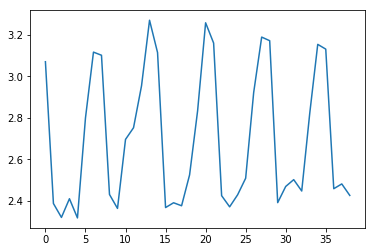

In [31]:
plt.plot(testpreds[129])

In [32]:
preddf=pd.DataFrame(testpreds,index= rrvf_data.idx_to_store(range(testpreds.shape[0]))
                    ,columns= rrvf_data.idx_to_date(range(478,478+39)))
preddf=preddf.unstack().reset_index()
preddf.columns=['date','store','transformed_visitors']
preddf['id']=preddf[['store','date']].apply(lambda u: "_".join(u.values),axis=1)
preddf['visitors']=np.expm1(preddf['transformed_visitors'])
preddf=preddf.set_index(preddf['id'])
preddf.shape

(32331, 5)

In [33]:
preddf.head()

date                 store  \
id                                                                  
air_00a91d42b08b08d9_2017-04-23  2017-04-23  air_00a91d42b08b08d9   
air_0164b9927d20bcc3_2017-04-23  2017-04-23  air_0164b9927d20bcc3   
air_0241aa3964b7f861_2017-04-23  2017-04-23  air_0241aa3964b7f861   
air_0328696196e46f18_2017-04-23  2017-04-23  air_0328696196e46f18   
air_034a3d5b40d5b1b1_2017-04-23  2017-04-23  air_034a3d5b40d5b1b1   

                                 transformed_visitors  \
id                                                      
air_00a91d42b08b08d9_2017-04-23              2.033957   
air_0164b9927d20bcc3_2017-04-23              1.425182   
air_0241aa3964b7f861_2017-04-23              2.141759   
air_0328696196e46f18_2017-04-23              2.178843   
air_034a3d5b40d5b1b1_2017-04-23              3.471060   

                                                              id   visitors  
id                                                                           
air_00a91d42b08b08d9_2017-04-23  air_00a91d42b08b08d9_2017-04-23   6.644271  
air_0164b9927d20bcc3_2017-04-23  air_0164b9927d20bcc3_2017-04-23   3.158612  
air_0241aa3964b7f861_2017-04-23  air_0241aa3964b7f861_2017-04-23   7.514400  
air_0328696196e46f18_2017-04-23  air_0328696196e46f18_2017-04-23   7.836073  
air_034a3d5b40d5b1b1_2017-04-23  air_034a3d5b40d5b1b1_2017-04-23  31.170818

In [34]:
sample=pd.read_csv("../input/sample_submission.csv")
sample.shape

(32019, 2)

In [35]:
submission=preddf[['visitors']].loc[sample['id']]
submission.shape

(32019, 1)

In [36]:
submission.to_csv("../submission/3006_xgb_fold{}_{}_d{}.csv.gz".format(j, EXCLUDE_HARD, PRED_DATE)
                  ,compression='gzip')